Quantium Virtual Internship - Retail Strategy and Analytics - Task 2

In [8]:
import pandas as pd

In [9]:
trail_df = pd.read_csv('./clean_data/QVI_data.csv')
# Display the first few rows of the DataFrame
trail_df.head(3)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175.0,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175.0,CCS,MIDAGE SINGLES/COUPLES,Budget
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170.0,SMITHS,MIDAGE SINGLES/COUPLES,Budget


Select control stores

In [10]:
# Convert 'DATE' column to datetime if not already
trail_df['DATE'] = pd.to_datetime(trail_df['DATE'])

# Add a new column 'YEARMONTH' with the format yyyymm
trail_df['YEARMONTH'] = trail_df['DATE'].dt.year * 100 + trail_df['DATE'].dt.month
trail_df

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175.0,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175.0,CCS,MIDAGE SINGLES/COUPLES,Budget,201905
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170.0,SMITHS,MIDAGE SINGLES/COUPLES,Budget,201905
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175.0,SMITHS,MIDAGE SINGLES/COUPLES,Budget,201808
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150.0,KETTLE,MIDAGE SINGLES/COUPLES,Budget,201808
...,...,...,...,...,...,...,...,...,...,...,...,...,...
246735,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,175.0,KETTLE,YOUNG SINGLES/COUPLES,Premium,201903
246736,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,175.0,TOSTITOS,YOUNG SINGLES/COUPLES,Premium,201808
246737,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,170.0,DORITOS,YOUNG SINGLES/COUPLES,Premium,201811
246738,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,150.0,DORITOS,YOUNG SINGLES/COUPLES,Premium,201812


In [11]:
# Define measure calculations
measure_over_time = trail_df.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales=('TOT_SALES', 'sum'),
    nCustomers=('LYLTY_CARD_NBR', 'nunique'),
    nTxnPerCust=('TXN_ID', 'nunique'),
    nChipsPerTxn=('PROD_QTY', 'sum'),
    avgPricePerUnit=('TOT_SALES', 'sum')
).reset_index()

# Calculate additional measures outside the agg function
measure_over_time['nTxnPerCust'] /= measure_over_time['nCustomers']
measure_over_time['nChipsPerTxn'] /= measure_over_time['nTxnPerCust']
measure_over_time['avgPricePerUnit'] /= measure_over_time['nChipsPerTxn']

# Sort the DataFrame
measure_over_time.sort_values(by=['STORE_NBR', 'YEARMONTH'], inplace=True)

# Filter to the pre-trial period and stores with full observation periods
stores_with_full_obs = measure_over_time.groupby('STORE_NBR').size()[lambda x: x == 12].index
pre_trial_measures = measure_over_time[(measure_over_time['YEARMONTH'] < 201902) & (measure_over_time['STORE_NBR'].isin(stores_with_full_obs))]

Now we need to work out a way of ranking how similar each potential control store is to the trial store. We can calculate how correlated the performance of each store is to the trial store. Let’s write a function for this so that we don’t have to calculate this for each trial store and control store pair.

In [12]:
def calculate_correlation(input_table, metric_col, store_comparison):
    calc_corr_table = pd.DataFrame(columns=['Store1', 'Store2', 'corr_measure'])
    store_numbers = input_table['STORE_NBR'].unique()

    for store in store_numbers:
        if store != store_comparison:
            calculated_measure = pd.DataFrame({
                'Store1': [store_comparison],
                'Store2': [store],
                'corr_measure': [np.corrcoef(
                    input_table.loc[input_table['STORE_NBR'] == store_comparison, metric_col],
                    input_table.loc[input_table['STORE_NBR'] == store, metric_col]
                )[0, 1]]
            })
            calc_corr_table = pd.concat([calc_corr_table, calculated_measure], ignore_index=True)

    return calc_corr_table



Apart from correlation, we can also calculate a standardised metric based on the absolute difference between the trial store’s performance and each control store’s performance. Let’s write a function for this.

In [13]:
import pandas as pd

def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    calc_dist_table = pd.DataFrame(columns=['Store1', 'Store2', 'YEARMONTH', 'measure'])
    store_numbers = input_table['STORE_NBR'].unique()

    for store in store_numbers:
        if store != store_comparison:
            calculated_measure = pd.DataFrame({
                'Store1': [store_comparison],
                'Store2': [store],
                'YEARMONTH': input_table.loc[input_table['STORE_NBR'] == store_comparison, 'YEARMONTH'].values[0],
                'measure': [abs(input_table.loc[input_table['STORE_NBR'] == store_comparison, metric_col].values[0] -
                               input_table.loc[input_table['STORE_NBR'] == store, metric_col].values[0])]
            })
            calc_dist_table = pd.concat([calc_dist_table, calculated_measure], ignore_index=True)

    # Standardize the magnitude distance
    min_max_dist = calc_dist_table.groupby(['Store1', 'YEARMONTH'])['measure'].agg(['min', 'max']).reset_index()
    dist_table = pd.merge(calc_dist_table, min_max_dist, on=['Store1', 'YEARMONTH'], how='inner')
    dist_table['magnitudeMeasure'] = 1 - (dist_table['measure'] - dist_table['min']) / (dist_table['max'] - dist_table['min'])

    # Calculate the final magnitude measure for each pair of stores
    final_dist_table = dist_table.groupby(['Store1', 'Store2']).agg(mag_measure=('magnitudeMeasure', 'mean')).reset_index()

    return final_dist_table


Now let’s use the functions to find the control stores! We’ll select control stores based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores. So we will need to use our functions to get four scores, two for each of total sales and total customers.

In [15]:
import numpy as np
trial_store = 77

# Calculate correlation with store 77 for total sales
corr_nSales = calculate_correlation(pre_trial_measures, metric_col='totSales', store_comparison=trial_store)

# Display the result, ordered by correlation measure in descending order
corr_nSales_sorted = corr_nSales.sort_values(by='corr_measure', ascending=False)
print(corr_nSales_sorted)

/var/folders/tz/36qz0vtn4rb0h9dh9ghf_dpr0000gp/T/ipykernel_1089/284713565.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  calc_corr_table = pd.concat([calc_corr_table, calculated_measure], ignore_index=True)


    Store1 Store2  corr_measure
219     77    233      0.973643
46      77     50      0.897701
153     77    162      0.857584
67      77     71      0.815635
148     77    157      0.776545
..     ...    ...           ...
230     77    244     -0.729337
71      77     75     -0.795206
228     77    242     -0.804104
8       77      9     -0.813285
176     77    186     -0.917131

[258 rows x 3 columns]


In [16]:
# Calculate correlation with store 77 for the number of customers
trial_store = 77
corr_nCustomers = calculate_correlation(pre_trial_measures, metric_col='nCustomers', store_comparison=trial_store)

# Display the result, ordered by correlation measure in descending order
corr_nCustomers_sorted = corr_nCustomers.sort_values(by='corr_measure', ascending=False)
print(corr_nCustomers_sorted)


/var/folders/tz/36qz0vtn4rb0h9dh9ghf_dpr0000gp/T/ipykernel_1089/284713565.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  calc_corr_table = pd.concat([calc_corr_table, calculated_measure], ignore_index=True)


    Store1 Store2  corr_measure
219     77    233      0.965682
110     77    119      0.919064
105     77    113      0.901630
239     77    254      0.901610
32      77     35      0.892741
..     ...    ...           ...
213     77    227     -0.750629
176     77    186     -0.766873
160     77    169     -0.784241
8       77      9     -0.804504
50      77     54     -0.831480

[258 rows x 3 columns]


In [17]:
# Calculate magnitude distance for total sales
magnitude_nSales = calculate_magnitude_distance(pre_trial_measures, metric_col='totSales', store_comparison=trial_store)

# Calculate magnitude distance for the number of customers
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_measures, metric_col='nCustomers', store_comparison=trial_store)


/var/folders/tz/36qz0vtn4rb0h9dh9ghf_dpr0000gp/T/ipykernel_1089/2229950483.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  calc_dist_table = pd.concat([calc_dist_table, calculated_measure], ignore_index=True)


We’ll need to combine the all the scores calculated using our function to create a composite score to rank on. Let’s take a simple average of the correlation and magnitude scores for each driver. Note that if we consider it more important for the trend of the drivers to be similar, we can increase the weight of the correlation score (a simple average gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of the drivers to be more important, we can lower the weight of the correlation score.


In [18]:
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=["Store1", "Store2"])
score_nSales["scoreNSales"] = (score_nSales["corr_measure"] + score_nSales["mag_measure"]) / 2

score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=["Store1", "Store2"])
score_nCustomers["scoreNCust"] = (score_nCustomers["corr_measure"] + score_nCustomers["mag_measure"]) / 2

In [19]:
# Sort the DataFrame by 'scoreNSales' column in descending order
score_nSales_sorted = score_nSales.sort_values(by='scoreNSales', ascending=False)
print(score_nSales_sorted)

    Store1 Store2  corr_measure  mag_measure  scoreNSales
219     77    233      0.973643     0.998395     0.986019
46      77     50      0.897701     0.969979     0.933840
158     77    167      0.654668     0.958019     0.806343
38      77     41      0.659128     0.933617     0.796372
49      77     53      0.636529     0.949029     0.792779
..     ...    ...           ...          ...          ...
81      77     88     -0.308587     0.238240    -0.035173
129     77    138     -0.694149     0.591427    -0.051361
233     77    247     -0.710906     0.570718    -0.070094
3       77      4     -0.347846     0.157891    -0.094978
71      77     75     -0.795206     0.396452    -0.199377

[258 rows x 5 columns]


In [20]:
# Sort the DataFrame by 'scoreNCust' column in descending order
score_nCustomers_sorted = score_nCustomers.sort_values(by='scoreNCust', ascending=False)
print(score_nCustomers_sorted)

    Store1 Store2  corr_measure mag_measure scoreNCust
219     77    233      0.965682         1.0   0.982841
78      77     84      0.851521    0.945055   0.898288
239     77    254      0.901610     0.89011    0.89586
32      77     35      0.892741    0.857143   0.874942
25      77     27      0.765510    0.978022   0.871766
..     ...    ...           ...         ...        ...
71      77     75     -0.565016    0.472527  -0.046244
3       77      4     -0.305412    0.186813  -0.059299
138     77    147     -0.714896     0.56044  -0.077228
156     77    165     -0.364746    0.098901  -0.132922
213     77    227     -0.750629    0.472527  -0.139051

[258 rows x 5 columns]


Now we have a score for each of total number of sales and number of customers. Let’s combine the two via a simple average.

In [21]:
# Merge sales scores and customer scores
score_Control = pd.merge(score_nSales, score_nCustomers, on=["Store1", "Store2"])

# Calculate the final control score
score_Control['finalControlScore'] = score_Control['scoreNSales'] * 0.5 + score_Control['scoreNCust'] * 0.5

In [22]:
# Sort the DataFrame by 'finalControlScore' column in descending order
score_Control_sorted = score_Control.sort_values(by='finalControlScore', ascending=False)
print(score_Control_sorted)

    Store1 Store2  corr_measure_x  mag_measure_x  scoreNSales  corr_measure_y  \
219     77    233        0.973643       0.998395     0.986019        0.965682   
46      77     50        0.897701       0.969979     0.933840        0.709398   
32      77     35        0.691090       0.878391     0.784741        0.892741   
78      77     84        0.666157       0.838337     0.752247        0.851521   
158     77    167        0.654668       0.958019     0.806343        0.668652   
..     ...    ...             ...            ...          ...             ...   
138     77    147       -0.664014       0.659978    -0.002018       -0.714896   
233     77    247       -0.710906       0.570718    -0.070094       -0.543684   
213     77    227       -0.504082       0.542302     0.019110       -0.750629   
3       77      4       -0.347846       0.157891    -0.094978       -0.305412   
71      77     75       -0.795206       0.396452    -0.199377       -0.565016   

    mag_measure_y scoreNCus

The store with the highest score is then selected as the control store since it is most similar to the trial store.

In [23]:
# Filter the DataFrame for the trial store and select the second-highest finalControlScore
control_store = score_Control[score_Control['Store1'] == trial_store].sort_values(by='finalControlScore', ascending=False).iloc[1]['Store2']

print("Selected control store:", control_store)

Selected control store: 50


Now that we have found a control store, let’s check visually if the drivers are indeed similar in the period before the trial. We’ll look at total sales first.

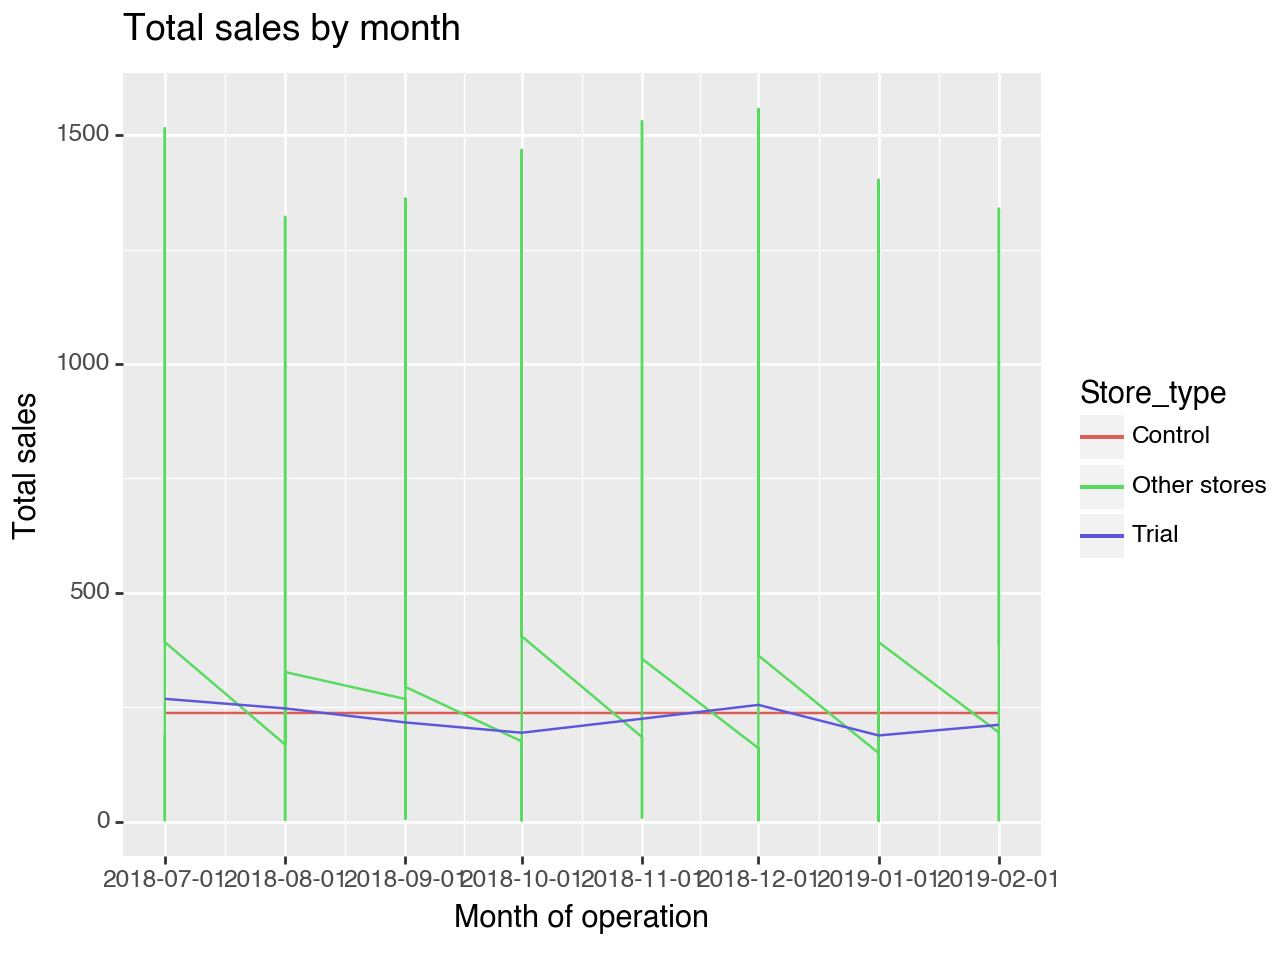

In [24]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_line, labs

# Assuming 'measure_over_time_sales', 'trial_store', and 'control_store' are your DataFrames
measure_over_time_sales = measure_over_time.copy()

# Add 'Store_type' column
measure_over_time_sales['Store_type'] = np.where(
    measure_over_time_sales['STORE_NBR'] == trial_store, 'Trial',
    np.where(measure_over_time_sales['STORE_NBR'] == control_store, 'Control', 'Other stores')
)

# Calculate mean total sales for the control store
measure_over_time_sales.loc[
    measure_over_time_sales['STORE_NBR'] == control_store, 'totSales'
] = measure_over_time_sales.loc[
    measure_over_time_sales['STORE_NBR'] == control_store, 'totSales'
].mean()

# Convert YEARMONTH to TransactionMonth
measure_over_time_sales['TransactionMonth'] = pd.to_datetime(measure_over_time_sales['YEARMONTH'], format='%Y%m')
measure_over_time_sales['MonthAbbrev'] = measure_over_time_sales['TransactionMonth'].dt.strftime('%b')


# Filter data for months before March 2019
past_sales = measure_over_time_sales[measure_over_time_sales['YEARMONTH'] < 201903]

# Create ggplot
plot = (
    ggplot(past_sales, aes(x='TransactionMonth', y='totSales', color='Store_type')) +
    geom_line() +
    labs(x='Month of operation', y='Total sales', title='Total sales by month')
)

# Display the plot
print(plot)


Next, number of customers.

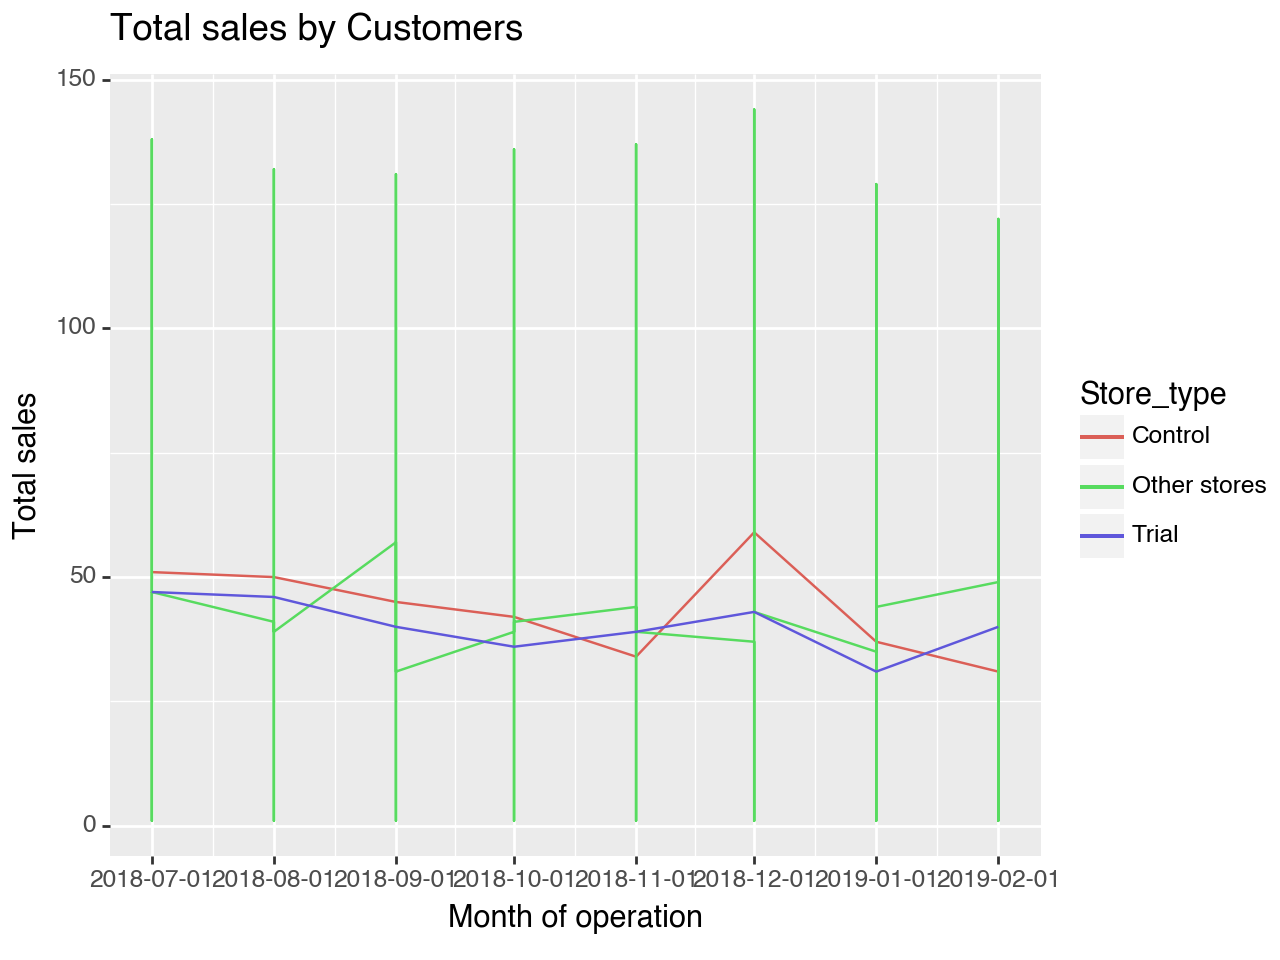

In [25]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_line, labs

# Assuming 'measure_over_time_sales', 'trial_store', and 'control_store' are your DataFrames
measure_over_time_sales = measure_over_time.copy()

# Add 'Store_type' column
measure_over_time_sales['Store_type'] = np.where(
    measure_over_time_sales['STORE_NBR'] == trial_store, 'Trial',
    np.where(measure_over_time_sales['STORE_NBR'] == control_store, 'Control', 'Other stores')
)

# Calculate mean total sales for the control store
measure_over_time_sales.loc[
    measure_over_time_sales['STORE_NBR'] == control_store, 'totSales'
] = measure_over_time_sales.loc[
    measure_over_time_sales['STORE_NBR'] == control_store, 'totSales'
].mean()

# Convert YEARMONTH to TransactionMonth
measure_over_time_sales['TransactionMonth'] = pd.to_datetime(measure_over_time_sales['YEARMONTH'], format='%Y%m')
measure_over_time_sales['MonthAbbrev'] = measure_over_time_sales['TransactionMonth'].dt.strftime('%b')


# Filter data for months before March 2019
past_sales = measure_over_time_sales[measure_over_time_sales['YEARMONTH'] < 201903]

# Create ggplot
plot = (
    ggplot(past_sales, aes(x='TransactionMonth', y='nCustomers', color='Store_type')) +
    geom_line() +
    labs(x='Month of operation', y='Total sales', title='Total sales by Customers')
)

# Display the plot
print(plot)


In [153]:
# Scale pre-trial control store sales
scaling_factor_for_control_sales = (
   pre_trial_measures.loc[(pre_trial_measures['STORE_NBR'] == trial_store) & (pre_trial_measures['YEARMONTH'] < 201902), 'totSales'].sum() /
    pre_trial_measures.loc[(pre_trial_measures['STORE_NBR'] == control_store) & (pre_trial_measures['YEARMONTH'] < 201902), 'totSales'].sum()
)

# Apply the scaling factor
measure_over_time_sales = measure_over_time.copy()
scaled_control_sales = (
    measure_over_time_sales.loc[measure_over_time_sales['STORE_NBR'] == control_store]
    .assign(controlSales=lambda x: x['totSales'] * scaling_factor_for_control_sales)
)


In [56]:
import pandas as pd


# Print some information for debugging
print("scaling_factor_for_control_sales:")
print(scaling_factor_for_control_sales)

print("measure_over_time:")
print(measure_over_time.head())

# Check the data types of the columns used for merging
print("Data types:")
print(scaling_factor_for_control_sales.dtypes)
print(measure_over_time.dtypes)

# Filter the control sales DataFrame
control_sales_subset = scaling_factor_for_control_sales[['YEARMONTH', 'controlSales']]

# Filter the measure over time DataFrame for the trial store
measure_subset = measure_over_time.loc[measure_over_time['STORE_NBR'] == trial_store, ['totSales', 'YEARMONTH']]  # Updated column name

# Rename 'totSales' to 'totalSales' to match the column name used later
measure_subset = measure_subset.rename(columns={'totSales': 'totalSales'})

# Print intermediate results for debugging
print("control_sales_subset:")
print(control_sales_subset.head())

print("measure_subset:")
print(measure_subset.head())

# Merge the DataFrames on 'YEARMONTH'
try:
    percentageDiff = pd.merge(control_sales_subset, measure_subset, on='YEARMONTH', how='inner')

    # Calculate percentage difference
    percentageDiff['percentageDiff'] = abs(percentageDiff['controlSales'] - percentageDiff['totalSales']) / percentageDiff['controlSales']

    # Print the result
    print("Result:")
    print(percentageDiff)
except Exception as e:
    print("An error occurred during merging and calculation:", e)


scaling_factor_for_control_sales:
   YEARMONTH  controlSales
0     201807      0.891889
measure_over_time:
   STORE_NBR  YEARMONTH  totSales  nCustomers  nTxnPerCust  nChipsPerTxn  \
0          1     201807     188.9          47     1.042553     55.632653   
1          1     201808     168.4          41     1.000000     52.000000   
2          1     201809     268.1          57     1.035088     68.593220   
3          1     201810     175.4          39     1.025641     49.725000   
4          1     201811     184.8          44     1.022727     53.777778   

   avgPricePerUnit  
0         3.395488  
1         3.238462  
2         3.908550  
3         3.527401  
4         3.436364  
Data types:
YEARMONTH         int64
controlSales    float64
dtype: object
STORE_NBR            int64
YEARMONTH            int32
totSales           float64
nCustomers           int64
nTxnPerCust        float64
nChipsPerTxn       float64
avgPricePerUnit    float64
dtype: object
control_sales_subset:
   YEARMONT

In [65]:
import pandas as pd


# Check the column names in measure_over_time
print("Column names in measure_over_time:", measure_over_time.columns)

# Check the column names in scaling_factor_for_control_sales
print("Column names in scaling_factor_for_control_sales:", scaling_factor_for_control_sales.columns)

# Merge the DataFrames on 'YEARMONTH'
percentageDiff = pd.merge(
    scaling_factor_for_control_sales[['YEARMONTH', 'controlSales']],
    measure_over_time.loc[measure_over_time['STORE_NBR'] == trial_store, ['totSales', 'YEARMONTH']],
    on='YEARMONTH',
    how='inner'
)

# Print the column names in the merged DataFrame
print("Column names in the merged DataFrame:", percentageDiff.columns)

# Calculate percentage difference
percentageDiff['percentageDiff'] = abs(percentageDiff['controlSales'] - percentageDiff['totSales']) / percentageDiff['controlSales']

# Print the result
print(percentageDiff)


Column names in measure_over_time: Index(['STORE_NBR', 'YEARMONTH', 'totSales', 'nCustomers', 'nTxnPerCust',
       'nChipsPerTxn', 'avgPricePerUnit'],
      dtype='object')
Column names in scaling_factor_for_control_sales: Index(['YEARMONTH', 'controlSales'], dtype='object')
Column names in the merged DataFrame: Index(['YEARMONTH', 'controlSales', 'totSales'], dtype='object')
   YEARMONTH  controlSales  totSales  percentageDiff
0     201807      0.891889     268.4      299.934353


In [68]:
import numpy as np
import pandas as pd

# Assuming you have already calculated percentageDiff

# Print information about percentageDiff
print("Info about percentageDiff:")
print(percentageDiff)

# Print unique values in the 'YEARMONTH' column
print("Unique YEARMONTH values:")
print(percentageDiff['YEARMONTH'].unique())

# Check the conditions for filtering
condition = (percentageDiff['YEARMONTH'] < 201905) & (percentageDiff['YEARMONTH'] > 201901)
print("Condition for filtering:")
print(condition)

# Print the rows that satisfy the condition
result = percentageDiff[condition][['TransactionMonth', 'tValue']]
print("Result:")
print(result)


Info about percentageDiff:
   YEARMONTH  controlSales  totSales  percentageDiff  tValue TransactionMonth
0     201807      0.891889     268.4      299.934353     inf       2018-07-01
Unique YEARMONTH values:
[201807]
Condition for filtering:
0    False
Name: YEARMONTH, dtype: bool
Result:
Empty DataFrame
Columns: [TransactionMonth, tValue]
Index: []


In [69]:
import numpy as np
import pandas as pd

# Assuming you have already calculated percentageDiff

# Calculate the standard deviation for rows where YEARMONTH is less than 201902
stdDev = np.std(percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff'])

# Degrees of freedom
degreesOfFreedom = 7

# Calculate the t-value
percentageDiff['tValue'] = (percentageDiff['percentageDiff'] - 0) / stdDev

# Convert 'YEARMONTH' to datetime format
percentageDiff['TransactionMonth'] = pd.to_datetime(
    percentageDiff['YEARMONTH'].astype(str),
    format='%Y%m'
)

# Filter based on t-value condition
result = percentageDiff[percentageDiff['tValue'].between(-2, 2)]  # Adjust the range as needed

print(result)


Empty DataFrame
Columns: [YEARMONTH, controlSales, totSales, percentageDiff, tValue, TransactionMonth]
Index: []


In [75]:
from scipy.stats import t

# Assuming you have already defined degreesOfFreedom
degreesOfFreedom = 7

# Calculate the 95% quantile for the t-distribution
confidence_interval = t.ppf(0.95, df=degreesOfFreedom)

# Use the confidence interval in your code as needed
print("95% Confidence Interval for t-distribution:", confidence_interval)


95% Confidence Interval for t-distribution: 1.894578605061305


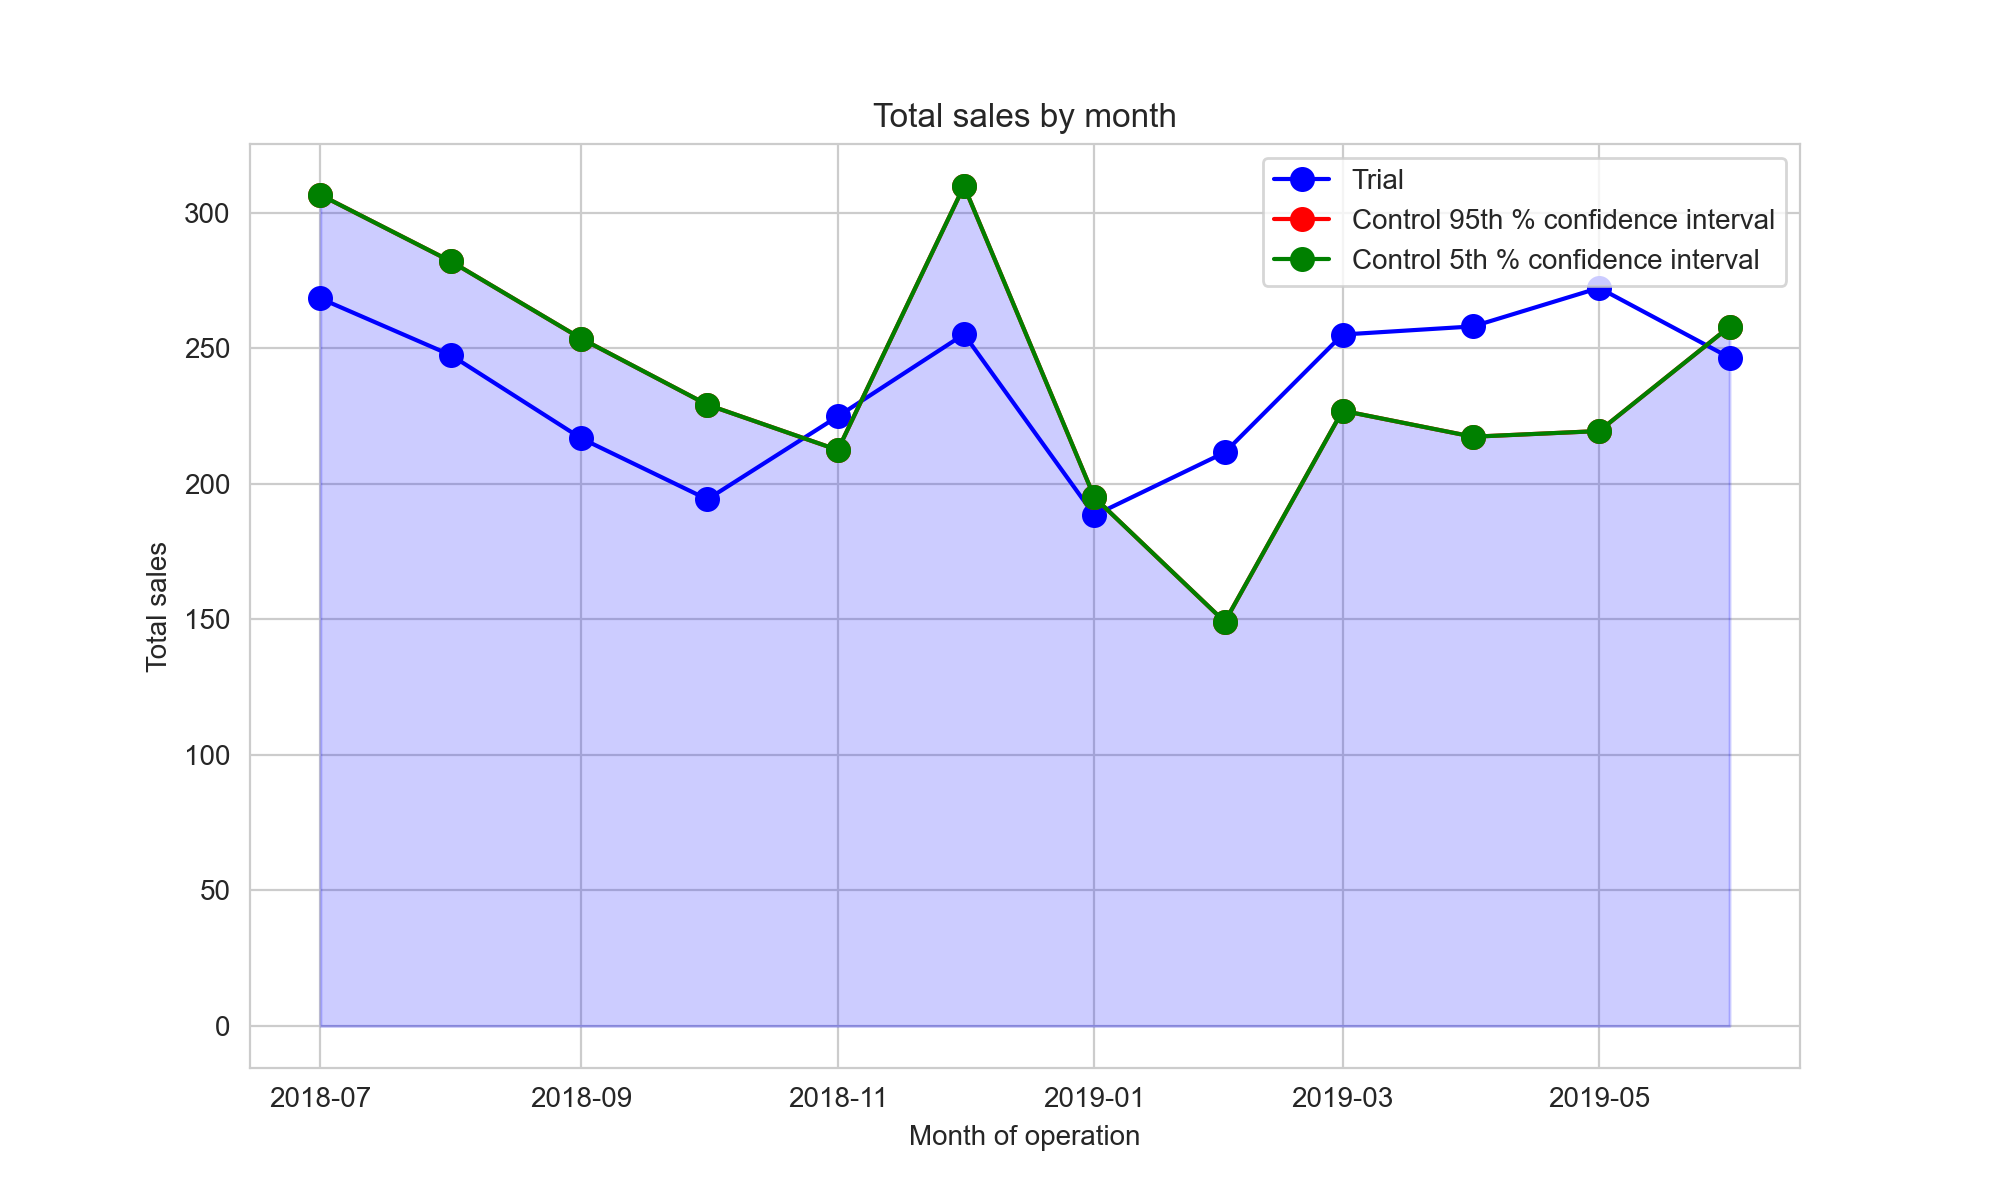

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the equivalent of measureOverTimeSales DataFrame
# Replace this with your actual DataFrame

# Create new variables Store_type, totSales, and TransactionMonth
measure_over_time['Store_type'] = np.where(measure_over_time['STORE_NBR'] == trial_store, 'Trial',
                                           np.where(measure_over_time['STORE_NBR'] == control_store, 'Control', 'Other stores'))

measure_over_time['totSales'] = measure_over_time.groupby(['YEARMONTH', 'Store_type'])['totSales'].transform('mean')
measure_over_time['TransactionMonth'] = pd.to_datetime(measure_over_time['YEARMONTH'].astype(str), format='%Y%m') + pd.offsets.MonthBegin(0)

# Filter for Trial and Control stores
pastSales = measure_over_time[measure_over_time['Store_type'].isin(['Trial', 'Control'])]

# Control store 95th percentile
pastSales_Controls95 = pastSales[pastSales['Store_type'] == 'Control'].copy()
pastSales_Controls95['totSales'] = pastSales_Controls95['totSales'] * (1 + stdDev * 2)
pastSales_Controls95['Store_type'] = 'Control 95th % confidence interval'

# Control store 5th percentile
pastSales_Controls5 = pastSales[pastSales['Store_type'] == 'Control'].copy()
pastSales_Controls5['totSales'] = pastSales_Controls5['totSales'] * (1 - stdDev * 2)
pastSales_Controls5['Store_type'] = 'Control 5th % confidence interval'

# Combine pastSales, pastSales_Controls95, and pastSales_Controls5
trialAssessment = pd.concat([pastSales, pastSales_Controls95, pastSales_Controls5])

# Plotting
plt.figure(figsize=(10, 6))

# Plot Trial
plt.plot(trialAssessment[trialAssessment['Store_type'] == 'Trial']['TransactionMonth'],
         trialAssessment[trialAssessment['Store_type'] == 'Trial']['totSales'],
         marker='o', linestyle='-', markersize=8, color='blue', label='Trial')

# Shade area between 95th % confidence interval and Trial
plt.fill_between(trialAssessment['TransactionMonth'],
                 trialAssessment['totSales'],
                 where=(trialAssessment['Store_type'] == 'Control 95th % confidence interval'),
                 color='blue', alpha=0.2)

# Plot Control 95th % confidence interval
plt.plot(trialAssessment[trialAssessment['Store_type'] == 'Control 95th % confidence interval']['TransactionMonth'],
         trialAssessment[trialAssessment['Store_type'] == 'Control 95th % confidence interval']['totSales'],
         marker='o', linestyle='-', markersize=8, color='red', label='Control 95th % confidence interval')

# Plot Control 5th % confidence interval
plt.plot(trialAssessment[trialAssessment['Store_type'] == 'Control 5th % confidence interval']['TransactionMonth'],
         trialAssessment[trialAssessment['Store_type'] == 'Control 5th % confidence interval']['totSales'],
         marker='o', linestyle='-', markersize=8, color='green', label='Control 5th % confidence interval')

plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Total sales by month")
plt.legend()
plt.show()


The results show that the trial in store 77 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months. Let’s have a look at assessing this for number of customers as well.

In [91]:
import pandas as pd

# Compute scaling factor for control store customers
scalingFactorForControlCust = pre_trial_measures.loc[(pre_trial_measures['STORE_NBR'] == trial_store) & (pre_trial_measures['YEARMONTH'] < 201902), 'nCustomers'].sum() / \
                               pre_trial_measures.loc[(pre_trial_measures['STORE_NBR'] == control_store) & (pre_trial_measures['YEARMONTH'] < 201902), 'nCustomers'].sum()

# Create a copy of measureOverTime for customer scaling
measureOverTimeCusts = measure_over_time.copy()

# Apply the scaling factor to control store customers
measureOverTimeCusts.loc[measureOverTimeCusts['STORE_NBR'] == control_store, 'controlCustomers'] = \
    measureOverTimeCusts.loc[measureOverTimeCusts['STORE_NBR'] == control_store, 'nCustomers'] * scalingFactorForControlCust

# Create Store_type variable
measureOverTimeCusts['Store_type'] = np.where(measureOverTimeCusts['STORE_NBR'] == trial_store, 'Trial',
                                               np.where(measureOverTimeCusts['STORE_NBR'] == control_store, 'Control', 'Other stores'))

# Merge and calculate percentage difference
percentageDiff = pd.merge(measureOverTimeCusts.loc[measureOverTimeCusts['STORE_NBR'] == control_store, ['YEARMONTH', 'controlCustomers']],
                          measureOverTimeCusts.loc[measureOverTimeCusts['STORE_NBR'] == trial_store, ['nCustomers', 'YEARMONTH']],
                          on='YEARMONTH', how='inner')

percentageDiff['percentageDiff'] = abs(percentageDiff['controlCustomers'] - percentageDiff['nCustomers']) / percentageDiff['controlCustomers']


Let’s again see if the difference is significant visually!

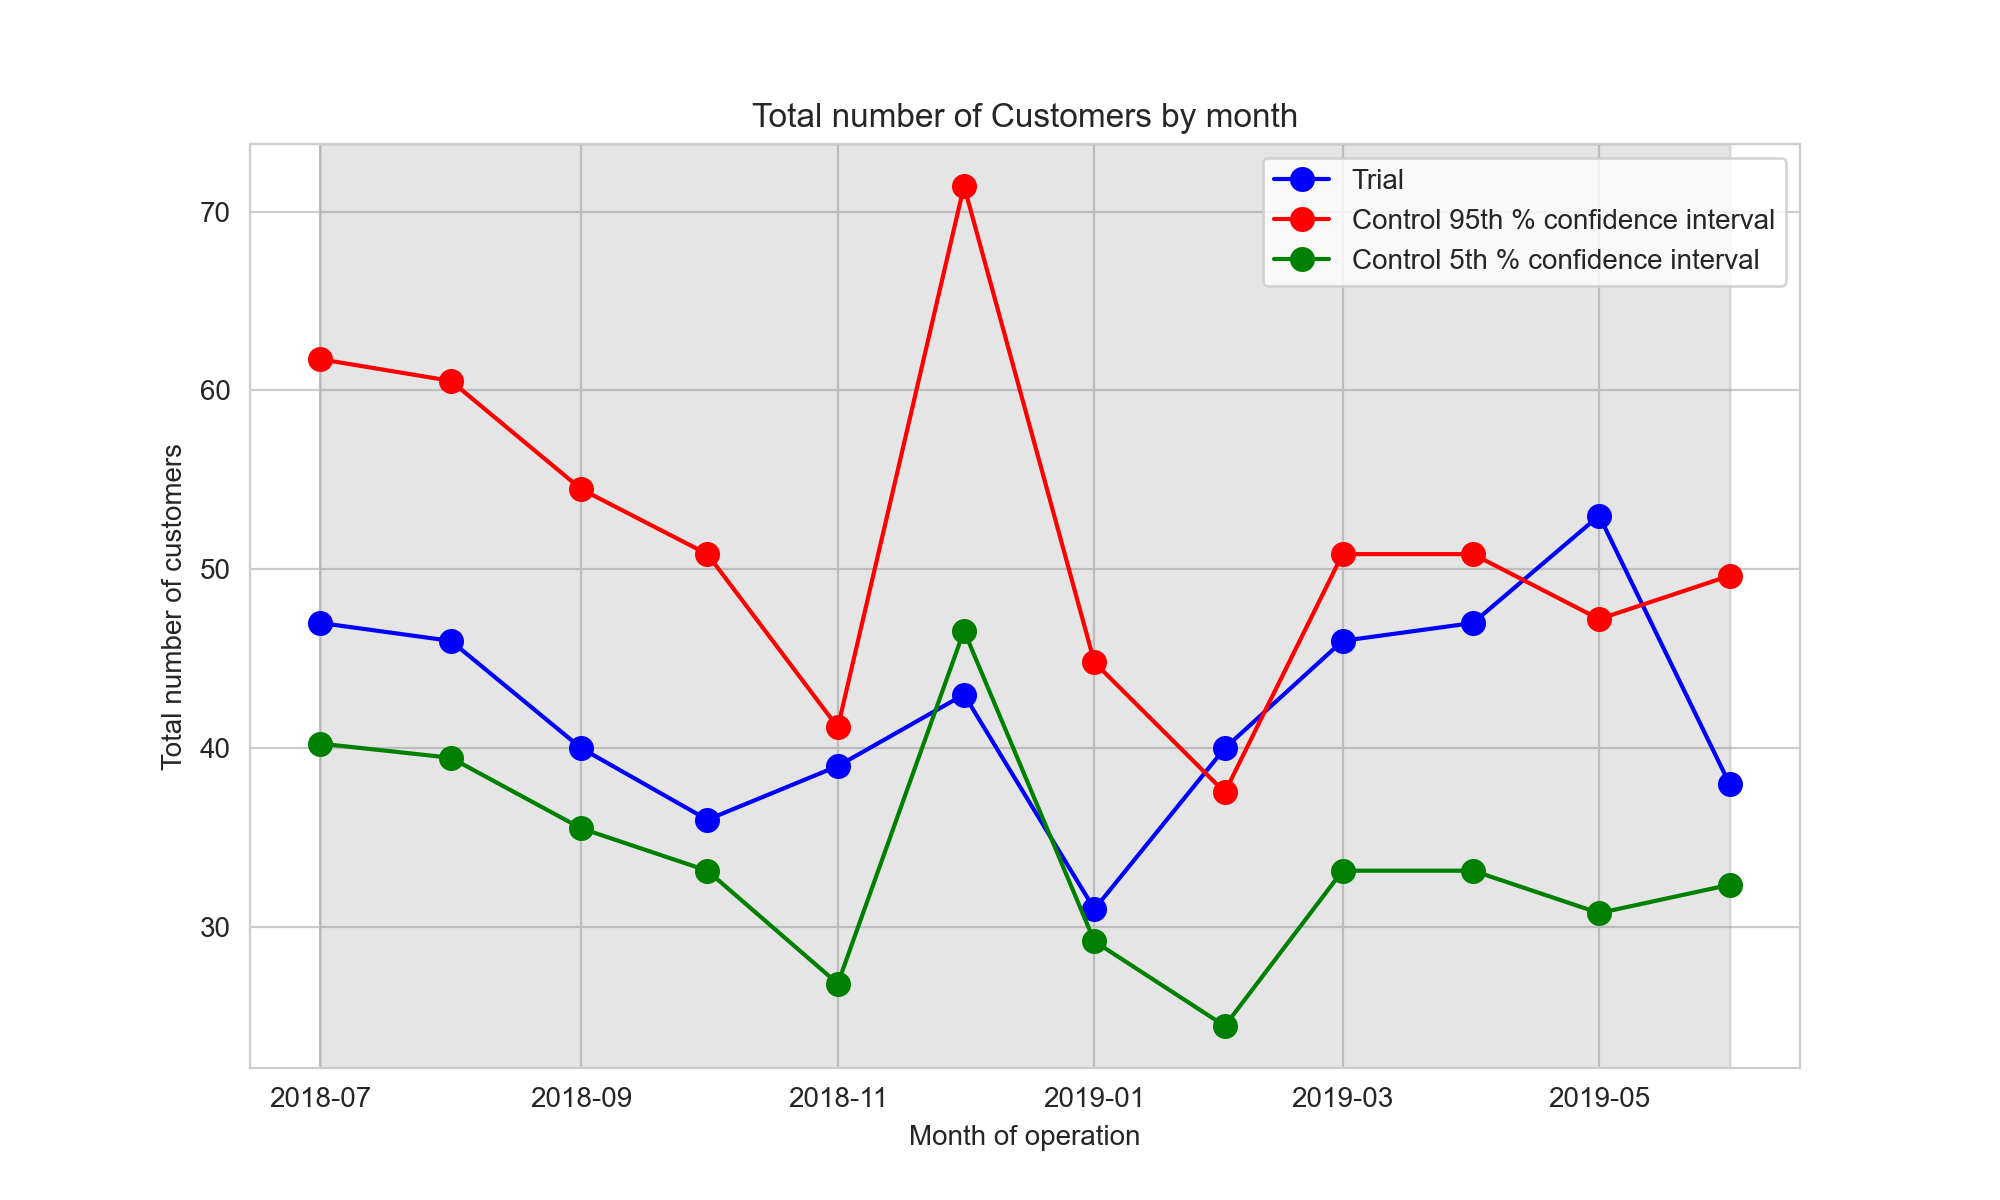

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the equivalent of measureOverTimeCusts DataFrame
# Replace this with your actual DataFrame

# Calculate the standard deviation based on the scaled percentage difference in the pre-trial period
stdDev = percentageDiff.loc[percentageDiff['YEARMONTH'] < 201902, 'percentageDiff'].std()
degreesOfFreedom = 7

# Calculate the mean number of customers by YEARMONTH and Store_type
pastCustomers = measureOverTimeCusts.groupby(['YEARMONTH', 'Store_type']).agg({'nCustomers': 'mean'}).reset_index()

# Separate trialAssessment and create a separate DataFrame for the trial store
trialAssessment = pastCustomers[pastCustomers['Store_type'] == 'Trial'].copy()

# Filter for Control stores
controlAssessment = pastCustomers[pastCustomers['Store_type'].isin(['Control'])]

# Control store 95th percentile
controlAssessment_95 = controlAssessment.copy()
controlAssessment_95['nCustomers'] = controlAssessment_95['nCustomers'] * (1 + stdDev * 2)
controlAssessment_95['Store_type'] = 'Control 95th % confidence interval'

# Control store 5th percentile
controlAssessment_5 = controlAssessment.copy()
controlAssessment_5['nCustomers'] = controlAssessment_5['nCustomers'] * (1 - stdDev * 2)
controlAssessment_5['Store_type'] = 'Control 5th % confidence interval'

# Combine trialAssessment, controlAssessment_95, and controlAssessment_5
assessment = pd.concat([trialAssessment, controlAssessment_95, controlAssessment_5])

# Create TransactionMonth column
assessment['TransactionMonth'] = pd.to_datetime(assessment['YEARMONTH'].astype(str), format='%Y%m') + pd.offsets.MonthBegin(0)

# Plotting
plt.figure(figsize=(10, 6))

# Plot Trial
plt.plot(assessment[assessment['Store_type'] == 'Trial']['TransactionMonth'],
         assessment[assessment['Store_type'] == 'Trial']['nCustomers'],
         marker='o', linestyle='-', markersize=8, color='blue', label='Trial')

# Highlight the trial period with a rectangle in the plot
plt.axvspan(assessment.loc[assessment['Store_type'] == 'Trial', 'TransactionMonth'].min(),
            assessment.loc[assessment['Store_type'] == 'Trial', 'TransactionMonth'].max(),
            color='gray', alpha=0.2)

# Plot Control 95th % confidence interval
plt.plot(assessment[assessment['Store_type'] == 'Control 95th % confidence interval']['TransactionMonth'],
         assessment[assessment['Store_type'] == 'Control 95th % confidence interval']['nCustomers'],
         marker='o', linestyle='-', markersize=8, color='red', label='Control 95th % confidence interval')

# Plot Control 5th % confidence interval
plt.plot(assessment[assessment['Store_type'] == 'Control 5th % confidence interval']['TransactionMonth'],
         assessment[assessment['Store_type'] == 'Control 5th % confidence interval']['nCustomers'],
         marker='o', linestyle='-', markersize=8, color='green', label='Control 5th % confidence interval')

plt.xlabel("Month of operation")
plt.ylabel("Total number of customers")
plt.title("Total number of Customers by month")
plt.legend()
plt.show()


Store 86

In [98]:
trial_store = 86

# Calculate correlation with store 77 for total sales
corr_nSales = calculate_correlation(pre_trial_measures, metric_col='totSales', store_comparison=trial_store)

# Display the result, ordered by correlation measure in descending order
corr_nSales_sorted = corr_nSales.sort_values(by='corr_measure', ascending=False)
print(corr_nSales_sorted)

/var/folders/tz/36qz0vtn4rb0h9dh9ghf_dpr0000gp/T/ipykernel_1089/284713565.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


    Store1 Store2  corr_measure
146     86    155      0.869532
123     86    132      0.842632
245     86    260      0.827631
129     86    138      0.796065
5       86      6      0.781804
..     ...    ...           ...
239     86    254     -0.797426
137     86    146     -0.811996
47      86     51     -0.816729
100     86    108     -0.835449
111     86    120     -0.887043

[258 rows x 3 columns]


In [99]:
# Calculate correlation with store 86 for the number of customers
trial_store = 86
corr_nCustomers = calculate_correlation(pre_trial_measures, metric_col='nCustomers', store_comparison=trial_store)

# Display the result, ordered by correlation measure in descending order
corr_nCustomers_sorted = corr_nCustomers.sort_values(by='corr_measure', ascending=False)
print(corr_nCustomers_sorted)


/var/folders/tz/36qz0vtn4rb0h9dh9ghf_dpr0000gp/T/ipykernel_1089/284713565.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


    Store1 Store2  corr_measure
106     86    114      0.855045
146     86    155      0.829086
211     86    225      0.787599
73      86     78      0.776887
167     86    176      0.756402
..     ...    ...           ...
170     86    180     -0.726974
203     86    216     -0.727595
59      86     63     -0.801173
21      86     23     -0.899089
244     86    259     -0.956674

[258 rows x 3 columns]


In [100]:
# Calculate magnitude distance for total sales
magnitude_nSales = calculate_magnitude_distance(pre_trial_measures, metric_col='totSales', store_comparison=trial_store)

# Calculate magnitude distance for the number of customers
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_measures, metric_col='nCustomers', store_comparison=trial_store)


/var/folders/tz/36qz0vtn4rb0h9dh9ghf_dpr0000gp/T/ipykernel_1089/2229950483.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [101]:
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=["Store1", "Store2"])
score_nSales["scoreNSales"] = (score_nSales["corr_measure"] + score_nSales["mag_measure"]) / 2

score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=["Store1", "Store2"])
score_nCustomers["scoreNCust"] = (score_nCustomers["corr_measure"] + score_nCustomers["mag_measure"]) / 2


In [102]:
# Sort the DataFrame by 'scoreNSales' column in descending order
score_nSales_sorted = score_nSales.sort_values(by='scoreNSales', ascending=False)
print(score_nSales_sorted)

    Store1 Store2  corr_measure  mag_measure  scoreNSales
146     86    155      0.869532     0.942864     0.906198
129     86    138      0.796065     0.915363     0.855714
208     86    222      0.741962     0.958748     0.850355
106     86    114      0.750924     0.927691     0.839308
209     86    223      0.662601     1.000000     0.831301
..     ...    ...           ...          ...          ...
239     86    254     -0.797426     0.142248    -0.327589
47      86     51     -0.816729     0.124467    -0.346131
39      86     42     -0.721833     0.025249    -0.348292
111     86    120     -0.887043     0.086771    -0.400136
137     86    146     -0.811996     0.007112    -0.402442

[258 rows x 5 columns]


In [103]:
# Sort the DataFrame by 'scoreNCust' column in descending order
score_nCustomers_sorted = score_nCustomers.sort_values(by='scoreNCust', ascending=False)
print(score_nCustomers_sorted)

    Store1 Store2  corr_measure mag_measure scoreNCust
211     86    225      0.787599         1.0   0.893799
146     86    155      0.829086    0.956989   0.893037
106     86    114      0.855045    0.913978   0.884512
73      86     78      0.776887    0.870968   0.823927
129     86    138      0.621938    0.924731   0.773335
..     ...    ...           ...         ...        ...
252     86    267     -0.393334    0.010753   -0.19129
39      86     42     -0.493679    0.064516  -0.214581
118     86    127     -0.494369    0.064516  -0.214926
137     86    146     -0.516902    0.021505  -0.247698
182     86    192     -0.662744    0.075269  -0.293737

[258 rows x 5 columns]


In [104]:
# Merge sales scores and customer scores
score_Control = pd.merge(score_nSales, score_nCustomers, on=["Store1", "Store2"])

# Calculate the final control score
score_Control['finalControlScore'] = score_Control['scoreNSales'] * 0.5 + score_Control['scoreNCust'] * 0.5

In [105]:
# Sort the DataFrame by 'finalControlScore' column in descending order
score_Control_sorted = score_Control.sort_values(by='finalControlScore', ascending=False)
print(score_Control_sorted)

    Store1 Store2  corr_measure_x  mag_measure_x  scoreNSales  corr_measure_y  \
146     86    155        0.869532       0.942864     0.906198        0.829086   
106     86    114        0.750924       0.927691     0.839308        0.855045   
129     86    138        0.796065       0.915363     0.855714        0.621938   
52      86     56        0.735300       0.760550     0.747925        0.676956   
209     86    223        0.662601       1.000000     0.831301        0.441886   
..     ...    ...             ...            ...          ...             ...   
48      86     52       -0.496469       0.013632    -0.241419       -0.400773   
182     86    192       -0.323119       0.033547    -0.144786       -0.662744   
39      86     42       -0.721833       0.025249    -0.348292       -0.493679   
111     86    120       -0.887043       0.086771    -0.400136       -0.567865   
137     86    146       -0.811996       0.007112    -0.402442       -0.516902   

    mag_measure_y scoreNCus

In [106]:
# Filter the DataFrame for the trial store and select the second-highest finalControlScore
control_store = score_Control[score_Control['Store1'] == trial_store].sort_values(by='finalControlScore', ascending=False).iloc[1]['Store2']

print("Selected control store:", control_store)

Selected control store: 114


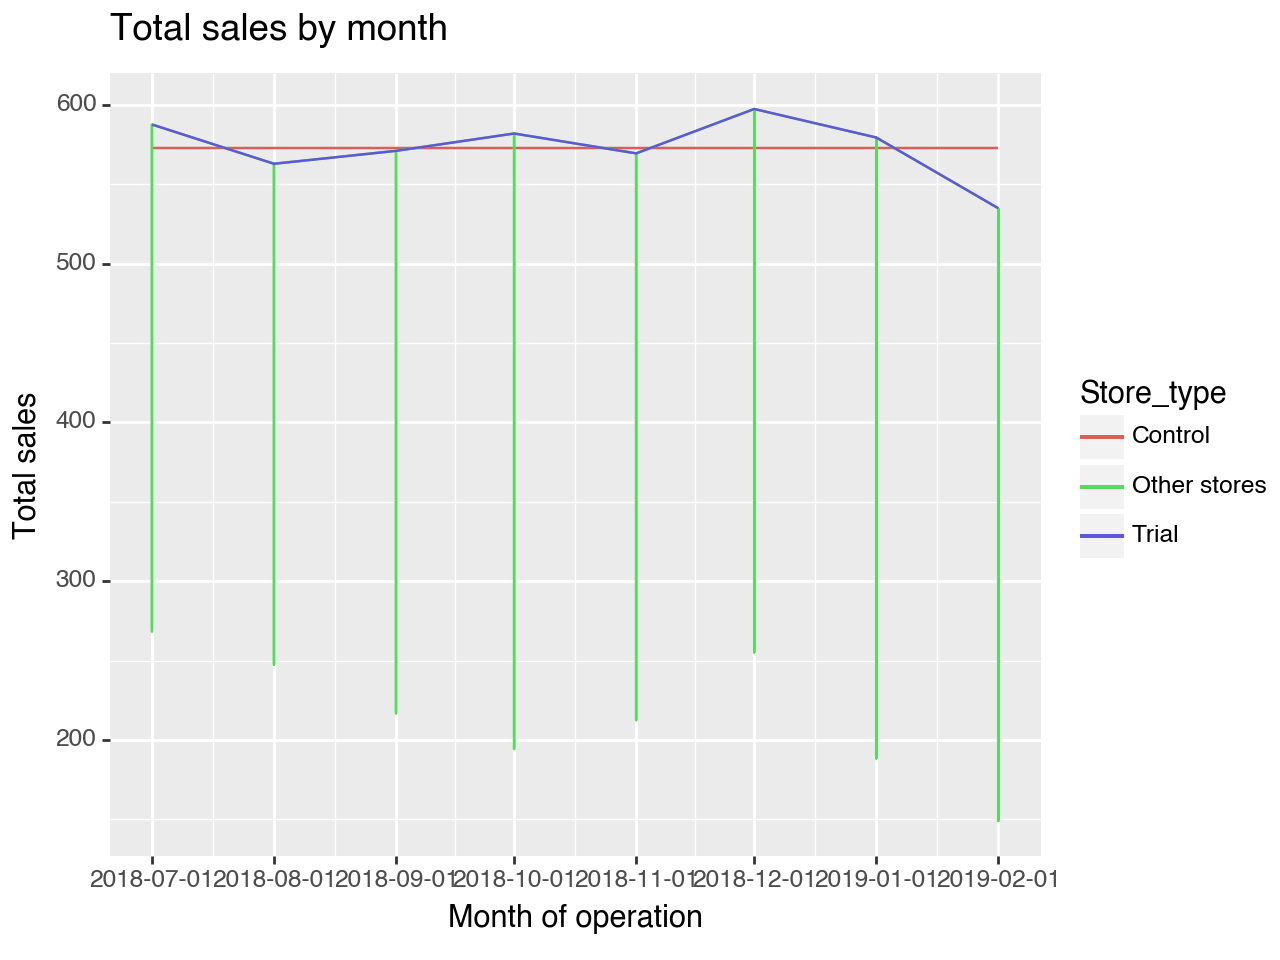

In [107]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_line, labs

# Assuming 'measure_over_time_sales', 'trial_store', and 'control_store' are your DataFrames
measure_over_time_sales = measure_over_time.copy()

# Add 'Store_type' column
measure_over_time_sales['Store_type'] = np.where(
    measure_over_time_sales['STORE_NBR'] == trial_store, 'Trial',
    np.where(measure_over_time_sales['STORE_NBR'] == control_store, 'Control', 'Other stores')
)

# Calculate mean total sales for the control store
measure_over_time_sales.loc[
    measure_over_time_sales['STORE_NBR'] == control_store, 'totSales'
] = measure_over_time_sales.loc[
    measure_over_time_sales['STORE_NBR'] == control_store, 'totSales'
].mean()

# Convert YEARMONTH to TransactionMonth
measure_over_time_sales['TransactionMonth'] = pd.to_datetime(measure_over_time_sales['YEARMONTH'], format='%Y%m')
measure_over_time_sales['MonthAbbrev'] = measure_over_time_sales['TransactionMonth'].dt.strftime('%b')


# Filter data for months before March 2019
past_sales = measure_over_time_sales[measure_over_time_sales['YEARMONTH'] < 201903]

# Create ggplot
plot = (
    ggplot(past_sales, aes(x='TransactionMonth', y='totSales', color='Store_type')) +
    geom_line() +
    labs(x='Month of operation', y='Total sales', title='Total sales by month')
)

# Display the plot
print(plot)


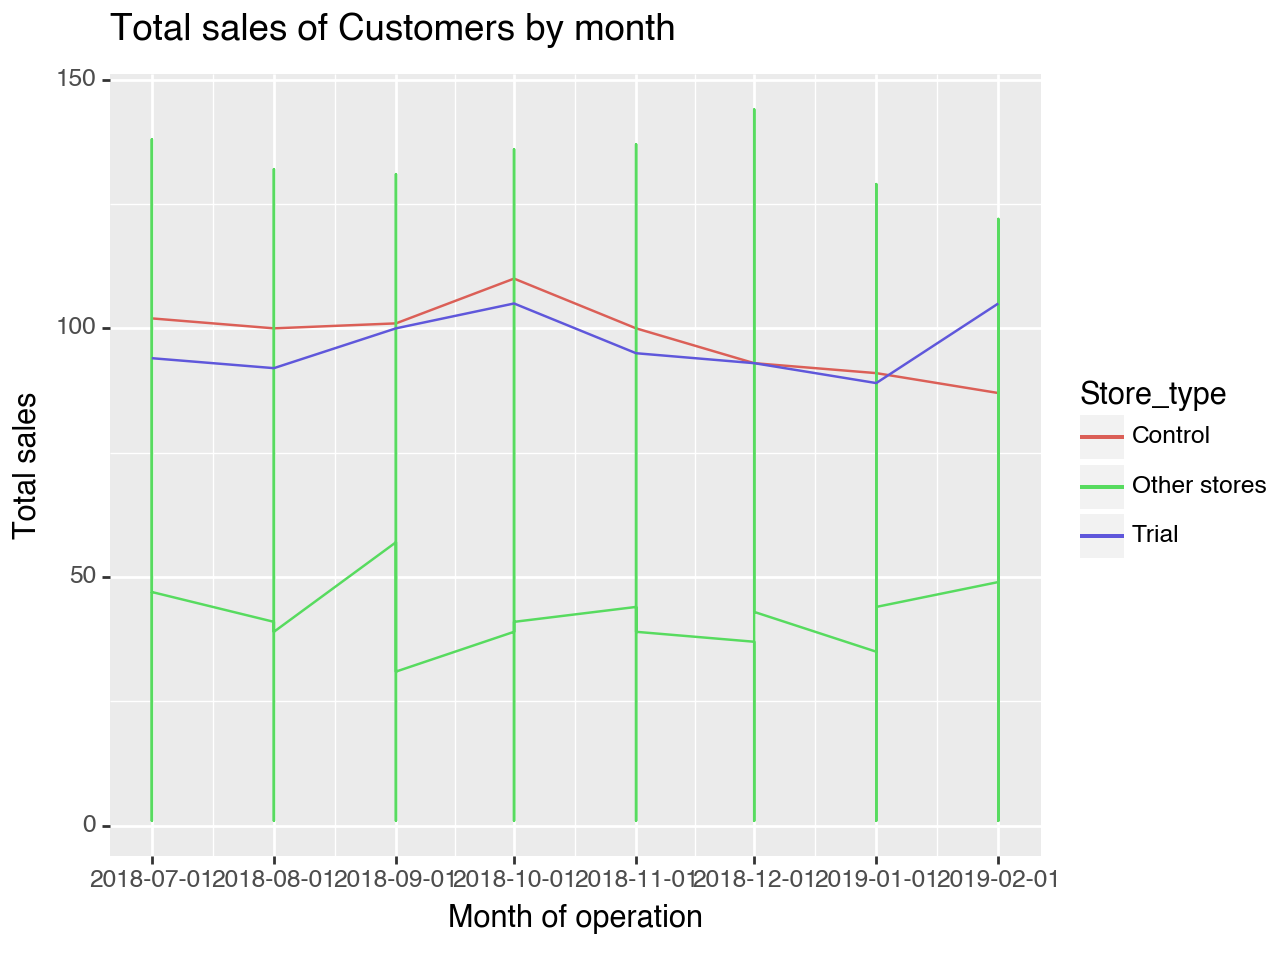

In [108]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_line, labs

# Assuming 'measure_over_time_sales', 'trial_store', and 'control_store' are your DataFrames
measure_over_time_sales = measure_over_time.copy()

# Add 'Store_type' column
measure_over_time_sales['Store_type'] = np.where(
    measure_over_time_sales['STORE_NBR'] == trial_store, 'Trial',
    np.where(measure_over_time_sales['STORE_NBR'] == control_store, 'Control', 'Other stores')
)

# Calculate mean total sales for the control store
measure_over_time_sales.loc[
    measure_over_time_sales['STORE_NBR'] == control_store, 'totSales'
] = measure_over_time_sales.loc[
    measure_over_time_sales['STORE_NBR'] == control_store, 'totSales'
].mean()

# Convert YEARMONTH to TransactionMonth
measure_over_time_sales['TransactionMonth'] = pd.to_datetime(measure_over_time_sales['YEARMONTH'], format='%Y%m')
measure_over_time_sales['MonthAbbrev'] = measure_over_time_sales['TransactionMonth'].dt.strftime('%b')


# Filter data for months before March 2019
past_sales = measure_over_time_sales[measure_over_time_sales['YEARMONTH'] < 201903]

# Create ggplot
plot = (
    ggplot(past_sales, aes(x='TransactionMonth', y='nCustomers', color='Store_type')) +
    geom_line() +
    labs(x='Month of operation', y='Total sales', title='Total sales of Customers by month')
)

# Display the plot
print(plot)


In [109]:
import pandas as pd
import numpy as np

# Scale pre-trial control sales to match pre-trial trial store sales
scalingFactorForControlSales = (pre_trial_measures[pre_trial_measures['STORE_NBR'] == trial_store]
                                .loc[pre_trial_measures['YEARMONTH'] < 201902, 'totSales'].sum() /
                                pre_trial_measures[pre_trial_measures['STORE_NBR'] == control_store]
                                .loc[pre_trial_measures['YEARMONTH'] < 201902, 'totSales'].sum())

# Apply the scaling factor
measure_over_time_sales['controlSales'] = np.where(measure_over_time_sales['STORE_NBR'] == control_store,
                                                measure_over_time_sales['totSales'] * scalingFactorForControlSales,
                                                measure_over_time_sales['totSales'])

# Calculate the percentage difference between scaled control sales and trial sales
# When calculating percentage difference, remember to use absolute difference
percentageDiff = pd.merge(measure_over_time_sales.loc[measure_over_time_sales['STORE_NBR'] == trial_store, ['YEARMONTH', 'totSales']],
                         measure_over_time_sales.loc[measure_over_time_sales['STORE_NBR'] == control_store, ['controlSales', 'YEARMONTH']],
                          on='YEARMONTH', how='inner')
percentageDiff['percentageDiff'] = abs(percentageDiff['controlSales'] - percentageDiff['totSales']) / percentageDiff['controlSales']

# Calculate the standard deviation of percentage differences during the pre-trial period
stdDev = percentageDiff.loc[percentageDiff['YEARMONTH'] < 201902, 'percentageDiff'].std()
degreesOfFreedom = 7


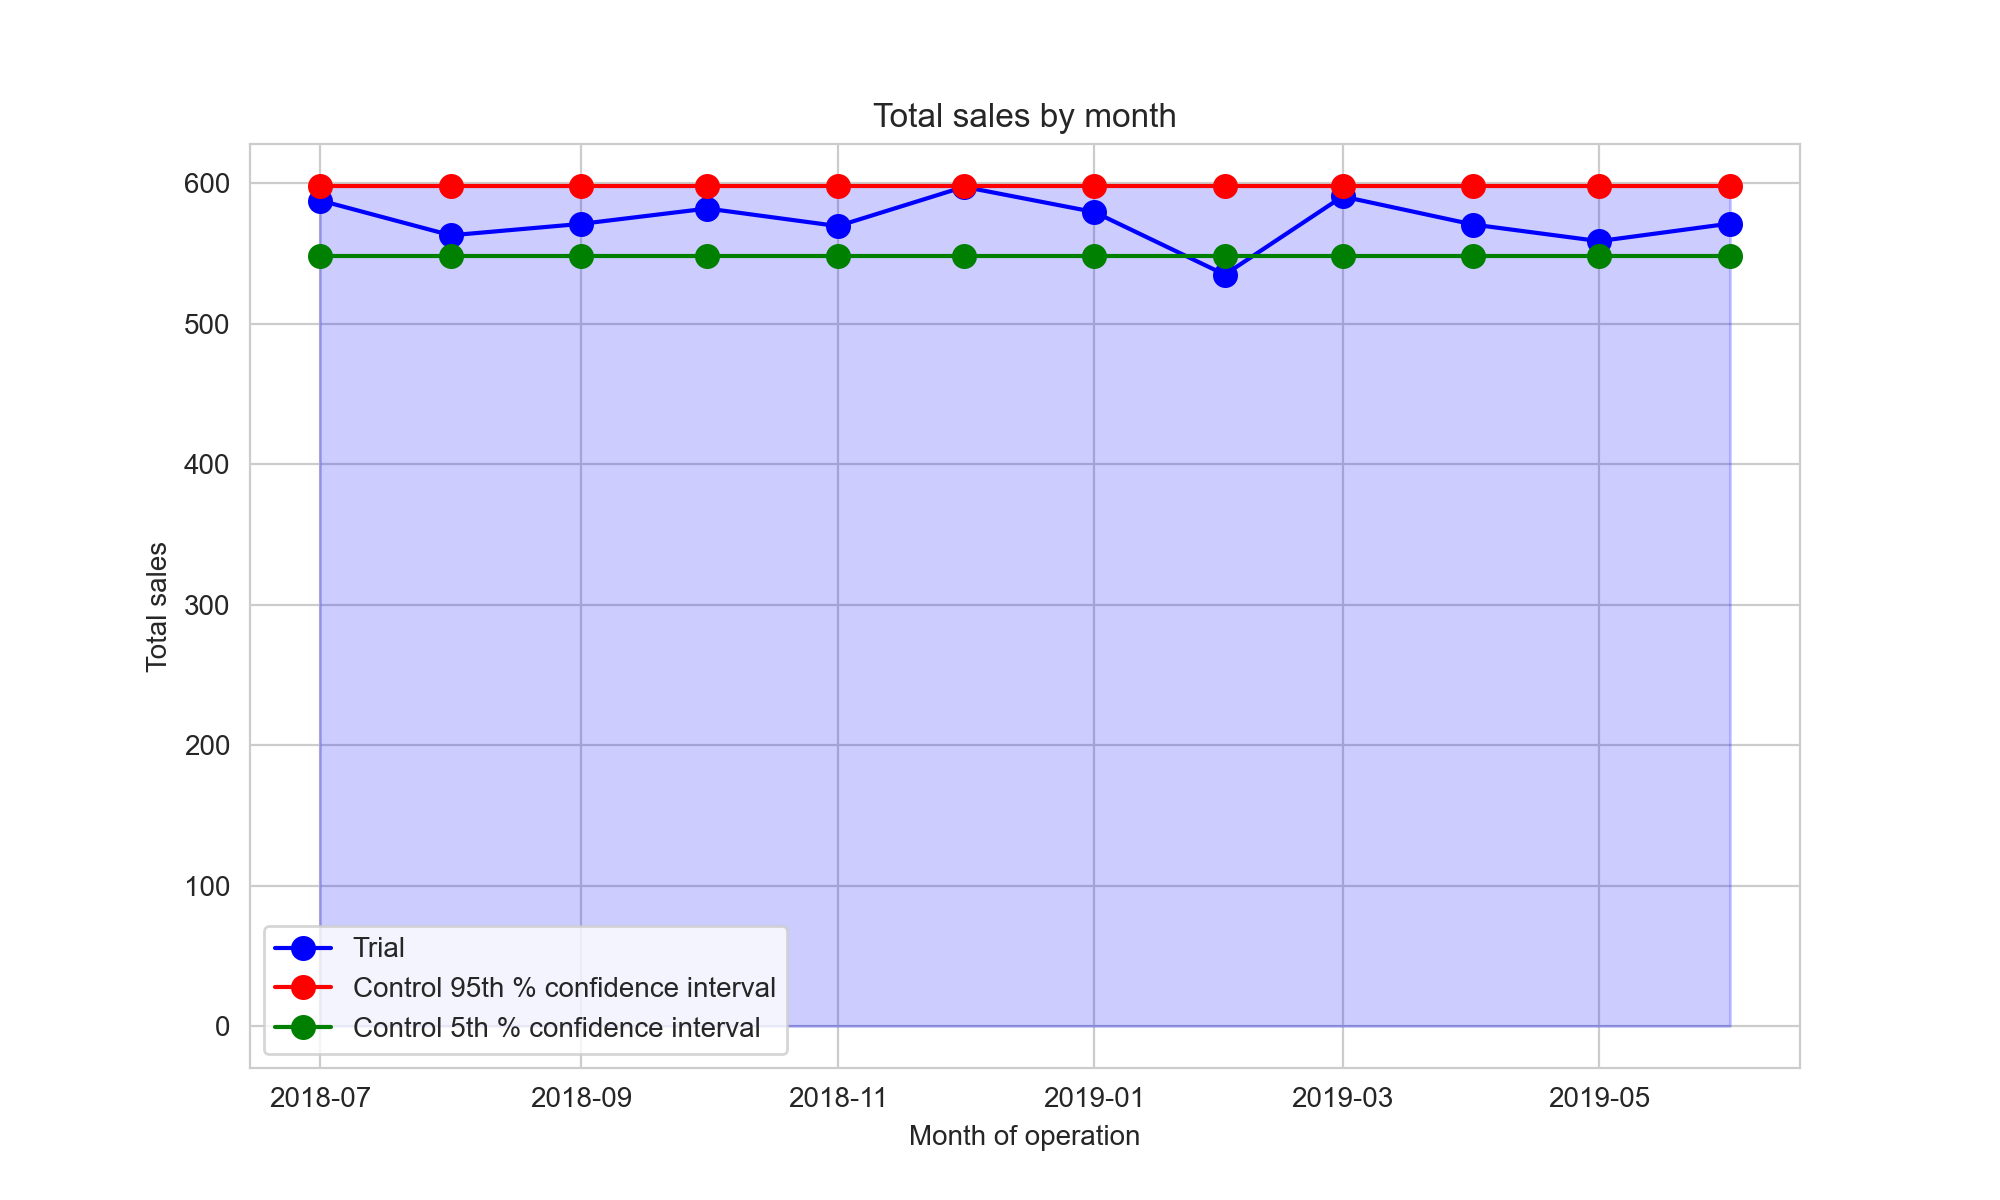

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the equivalent of measureOverTimeSales DataFrame
# Replace this with your actual DataFrame

# Create new variables Store_type, totSales, and TransactionMonth
measure_over_time_sales['Store_type'] = np.where(
    measure_over_time_sales['STORE_NBR'] == trial_store, 'Trial',
    np.where(measure_over_time_sales['STORE_NBR'] == control_store, 'Control', 'Other stores')
)

measure_over_time_sales['totSales'] = measure_over_time_sales.groupby(['YEARMONTH', 'Store_type'])['totSales'].transform('mean')
measure_over_time_sales['TransactionMonth'] = pd.to_datetime(measure_over_time_sales['YEARMONTH'].astype(str), format='%Y%m') + pd.offsets.MonthBegin(0)

# Filter for Trial and Control stores
past_sales = measure_over_time_sales[measure_over_time_sales['Store_type'].isin(['Trial', 'Control'])]

# Control store 95th percentile
past_sales_controls_95 = past_sales[past_sales['Store_type'] == 'Control'].copy()
past_sales_controls_95['totSales'] = past_sales_controls_95['totSales'] * (1 + stdDev * 2)
past_sales_controls_95['Store_type'] = 'Control 95th % confidence interval'

# Control store 5th percentile
past_sales_controls_5 = past_sales[past_sales['Store_type'] == 'Control'].copy()
past_sales_controls_5['totSales'] = past_sales_controls_5['totSales'] * (1 - stdDev * 2)
past_sales_controls_5['Store_type'] = 'Control 5th % confidence interval'

# Combine past_sales, past_sales_controls_95, and past_sales_controls_5
trial_assessment = pd.concat([past_sales, past_sales_controls_95, past_sales_controls_5])

# Plotting
plt.figure(figsize=(10, 6))

# Plot Trial
plt.plot(trial_assessment[trial_assessment['Store_type'] == 'Trial']['TransactionMonth'],
         trial_assessment[trial_assessment['Store_type'] == 'Trial']['totSales'],
         marker='o', linestyle='-', markersize=8, color='blue', label='Trial')

# Shade area between 95th % confidence interval and Trial
plt.fill_between(trial_assessment['TransactionMonth'],
                 trial_assessment['totSales'],
                 where=(trial_assessment['Store_type'] == 'Control 95th % confidence interval'),
                 color='blue', alpha=0.2)

# Plot Control 95th % confidence interval
plt.plot(trial_assessment[trial_assessment['Store_type'] == 'Control 95th % confidence interval']['TransactionMonth'],
         trial_assessment[trial_assessment['Store_type'] == 'Control 95th % confidence interval']['totSales'],
         marker='o', linestyle='-', markersize=8, color='red', label='Control 95th % confidence interval')

# Plot Control 5th % confidence interval
plt.plot(trial_assessment[trial_assessment['Store_type'] == 'Control 5th % confidence interval']['TransactionMonth'],
         trial_assessment[trial_assessment['Store_type'] == 'Control 5th % confidence interval']['totSales'],
         marker='o', linestyle='-', markersize=8, color='green', label='Control 5th % confidence interval')

plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Total sales by month")
plt.legend()
plt.show()


In [114]:
import pandas as pd
import numpy as np

# Assuming you have the equivalent of preTrialMeasures and measureOverTime DataFrames
# Replace this with your actual DataFrames

# Scale pre-trial control customers to match pre-trial trial store customers
scaling_factor_for_control_cust = (pre_trial_measures[pre_trial_measures['STORE_NBR'] == trial_store]
                                   ['nCustomers'].sum() /
                                   pre_trial_measures[pre_trial_measures['STORE_NBR'] == control_store]
                                   ['nCustomers'].sum())

# Apply the scaling factor
measure_over_time_custs = measure_over_time.copy()
scaled_control_customers = (measure_over_time_custs[measure_over_time_custs['STORE_NBR'] == control_store]
                             .assign(controlCustomers=lambda x: x['nCustomers'] * scaling_factor_for_control_cust)
                             .assign(Store_type=lambda x: np.where(x['STORE_NBR'] == trial_store, 'Trial',
                                                                    np.where(x['STORE_NBR'] == control_store, 'Control', 'Other stores')))
                             )

# Calculate the percentage difference between scaled control customers and trial customers
percentage_diff = pd.merge(scaled_control_customers[['YEARMONTH', 'controlCustomers']],
                           measure_over_time[measure_over_time['STORE_NBR'] == trial_store][['nCustomers', 'YEARMONTH']],
                           on='YEARMONTH', how='inner')
percentage_diff['percentageDiff'] = abs(percentage_diff['controlCustomers'] - percentage_diff['nCustomers']) / percentage_diff['controlCustomers']


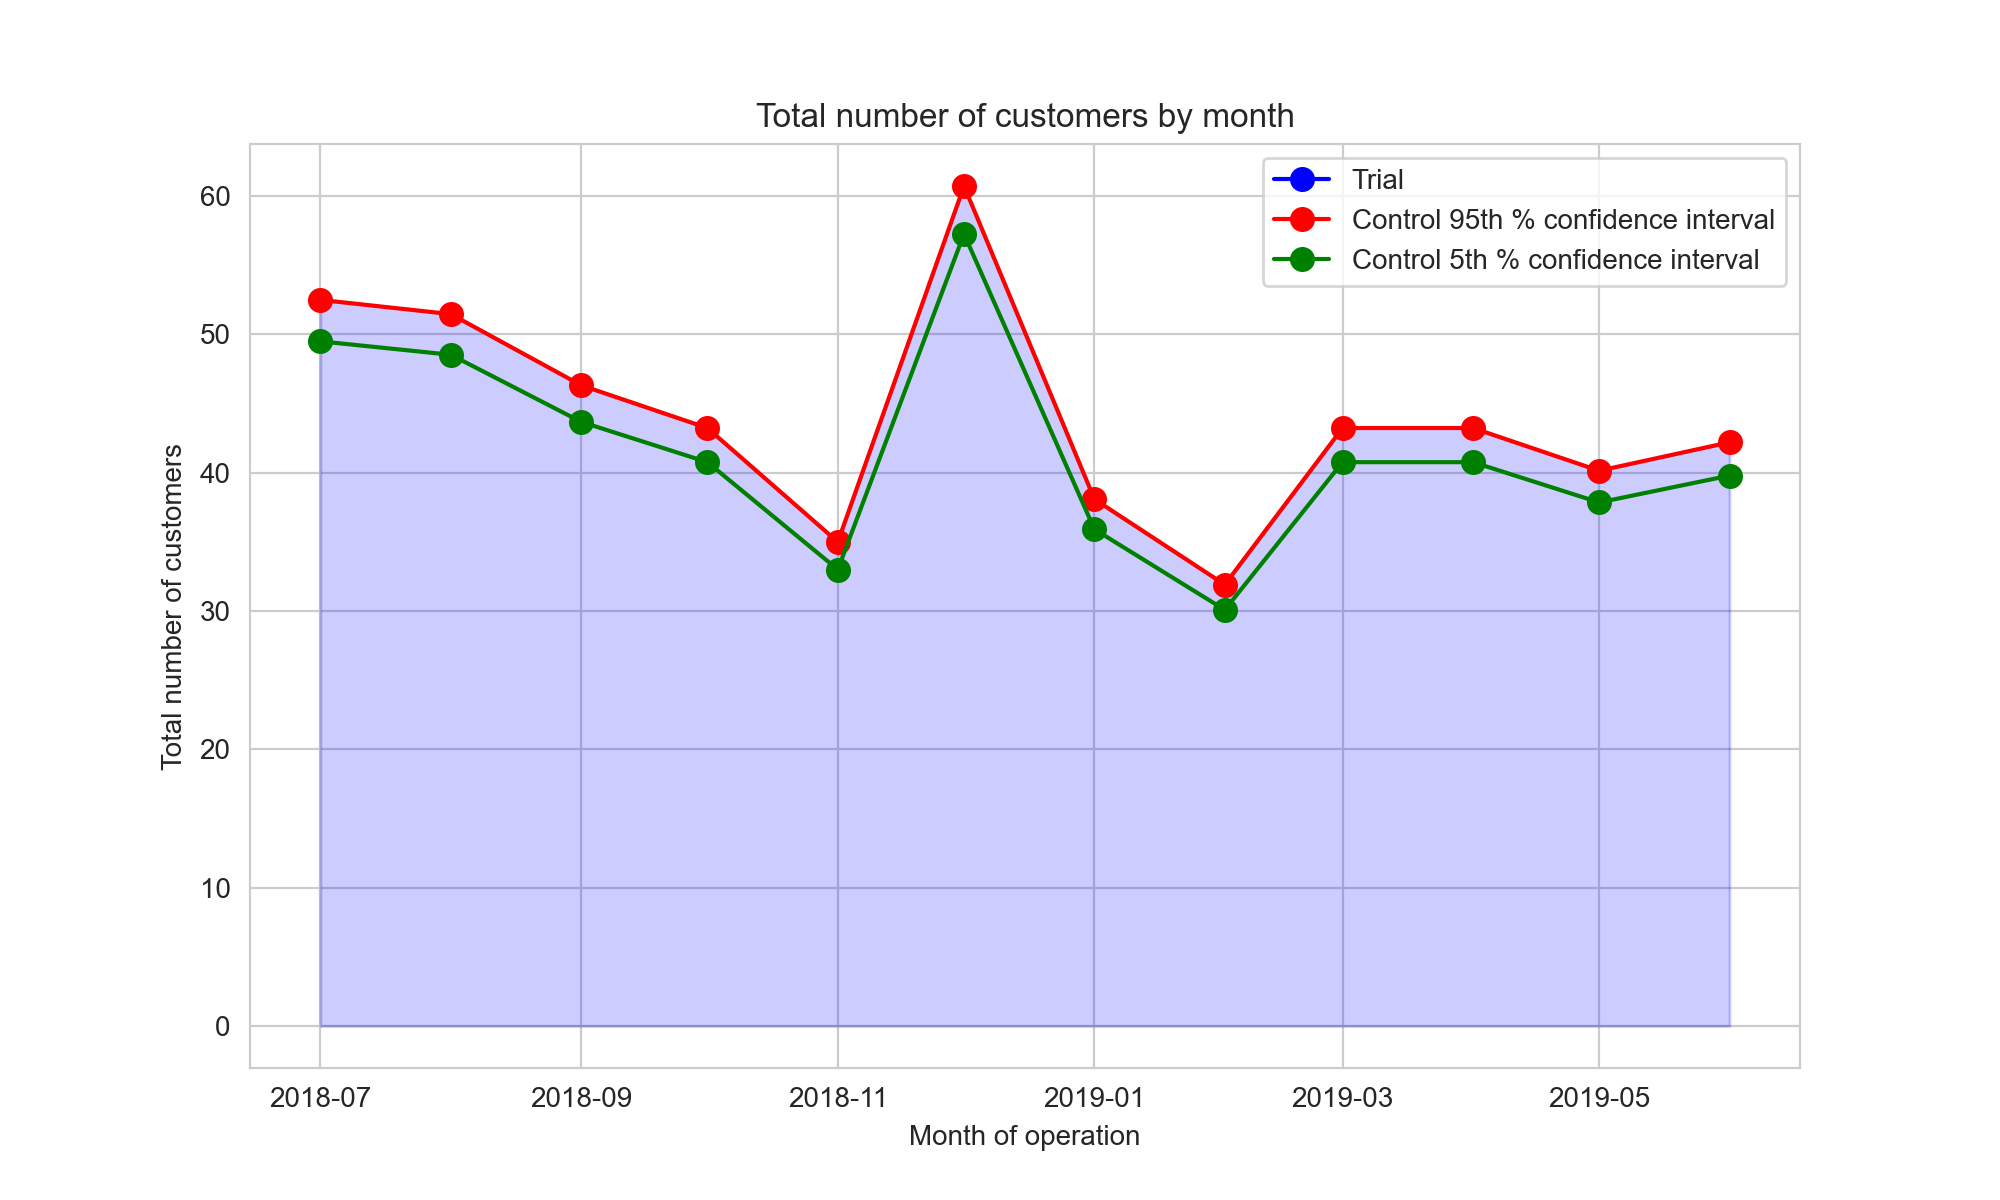

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the equivalent of measureOverTimeCusts DataFrame
# Replace this with your actual DataFrame

# Calculate standard deviation based on the scaled percentage difference in the pre-trial period
std_dev = np.std(percentage_diff[percentage_diff['YEARMONTH'] < 201902]['percentageDiff'])

degrees_of_freedom = 7

# Trial and control store number of customers
past_customers = (measure_over_time_custs.groupby(['YEARMONTH', 'Store_type'])
                  .agg({'nCustomers': 'mean'})
                  .reset_index())

# Filter for Trial and Control stores
past_customers = past_customers[past_customers['Store_type'].isin(['Trial', 'Control'])]

# Control store 95th percentile
past_customers_controls95 = past_customers[past_customers['Store_type'] == 'Control'].copy()
past_customers_controls95['nCusts'] = past_customers_controls95['nCustomers'] * (1 + std_dev * 2)
past_customers_controls95['Store_type'] = 'Control 95th % confidence interval'

# Control store 5th percentile
past_customers_controls5 = past_customers[past_customers['Store_type'] == 'Control'].copy()
past_customers_controls5['nCusts'] = past_customers_controls5['nCustomers'] * (1 - std_dev * 2)
past_customers_controls5['Store_type'] = 'Control 5th % confidence interval'

# Combine pastCustomers, pastCustomers_Controls95, and pastCustomers_Controls5
trial_assessment = pd.concat([past_customers, past_customers_controls95, past_customers_controls5])

# Convert YEARMONTH to TransactionMonth
trial_assessment['TransactionMonth'] = pd.to_datetime(trial_assessment['YEARMONTH'].astype(str), format='%Y%m') + pd.offsets.MonthBegin(0)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(trial_assessment[trial_assessment['Store_type'] == 'Trial']['TransactionMonth'],
         trial_assessment[trial_assessment['Store_type'] == 'Trial']['nCusts'],
         marker='o', linestyle='-', markersize=8, color='blue', label='Trial')
plt.fill_between(trial_assessment['TransactionMonth'],
                 trial_assessment['nCusts'],
                 where=(trial_assessment['Store_type'] == 'Control 95th % confidence interval'),
                 color='blue', alpha=0.2)
plt.plot(trial_assessment[trial_assessment['Store_type'] == 'Control 95th % confidence interval']['TransactionMonth'],
         trial_assessment[trial_assessment['Store_type'] == 'Control 95th % confidence interval']['nCusts'],
         marker='o', linestyle='-', markersize=8, color='red', label='Control 95th % confidence interval')
plt.plot(trial_assessment[trial_assessment['Store_type'] == 'Control 5th % confidence interval']['TransactionMonth'],
         trial_assessment[trial_assessment['Store_type'] == 'Control 5th % confidence interval']['nCusts'],
         marker='o', linestyle='-', markersize=8, color='green', label='Control 5th % confidence interval')
plt.xlabel("Month of operation")
plt.ylabel("Total number of customers")
plt.title("Total number of customers by month")
plt.legend()
plt.show()


It looks like the number of customers is significantly higher in all of the three months. This seems to suggest that the trial had a significant impact on increasing the number of customers in trial store 86 but as we saw, sales were not significantly higher. We should check with the Category Manager if there were special deals in the trial store that were may have resulted in lower prices, impacting the results

Store 88

In [118]:
trial_store = 88

# Calculate correlation with store 77 for total sales
corr_nSales = calculate_correlation(pre_trial_measures, metric_col='totSales', store_comparison=trial_store)

# Display the result, ordered by correlation measure in descending order
corr_nSales_sorted = corr_nSales.sort_values(by='corr_measure', ascending=False)
print(corr_nSales_sorted)

/var/folders/tz/36qz0vtn4rb0h9dh9ghf_dpr0000gp/T/ipykernel_1089/284713565.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


    Store1 Store2  corr_measure
150     88    159      0.938775
84      88     91      0.911986
193     88    204      0.871969
0       88      1      0.842232
226     88    240      0.817245
..     ...    ...           ...
166     88    175     -0.831593
216     88    230     -0.831631
221     88    235     -0.834842
21      88     23     -0.891573
44      88     48     -0.913144

[258 rows x 3 columns]


In [119]:
# Calculate correlation with store 86 for the number of customers
trial_store = 88
corr_nCustomers = calculate_correlation(pre_trial_measures, metric_col='nCustomers', store_comparison=trial_store)

# Display the result, ordered by correlation measure in descending order
corr_nCustomers_sorted = corr_nCustomers.sort_values(by='corr_measure', ascending=False)
print(corr_nCustomers_sorted)

/var/folders/tz/36qz0vtn4rb0h9dh9ghf_dpr0000gp/T/ipykernel_1089/284713565.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


    Store1 Store2  corr_measure
12      88     14      0.967364
223     88    237      0.958896
168     88    178      0.908365
72      88     77      0.863736
53      88     57      0.792889
..     ...    ...           ...
197     88    209     -0.707673
45      88     49     -0.712142
243     88    258     -0.729332
196     88    208     -0.807926
251     88    266     -0.837747

[258 rows x 3 columns]


In [120]:
# Calculate magnitude distance for total sales
magnitude_nSales = calculate_magnitude_distance(pre_trial_measures, metric_col='totSales', store_comparison=trial_store)

# Calculate magnitude distance for the number of customers
magnitude_nCustomers = calculate_magnitude_distance(pre_trial_measures, metric_col='nCustomers', store_comparison=trial_store)


/var/folders/tz/36qz0vtn4rb0h9dh9ghf_dpr0000gp/T/ipykernel_1089/2229950483.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [121]:
score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=["Store1", "Store2"])
score_nSales["scoreNSales"] = (score_nSales["corr_measure"] + score_nSales["mag_measure"]) / 2

score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=["Store1", "Store2"])
score_nCustomers["scoreNCust"] = (score_nCustomers["corr_measure"] + score_nCustomers["mag_measure"]) / 2

In [122]:
# Sort the DataFrame by 'scoreNSales' column in descending order
score_nSales_sorted = score_nSales.sort_values(by='scoreNSales', ascending=False)
print(score_nSales_sorted)

    Store1 Store2  corr_measure  mag_measure  scoreNSales
74      88     79      0.771989     0.820384     0.796186
84      88     91      0.911986     0.662341     0.787163
6       88      7      0.698846     0.825178     0.762012
98      88    106      0.614378     0.804926     0.709652
211     88    225      0.735724     0.652009     0.693866
..     ...    ...           ...          ...          ...
142     88    151     -0.533913     0.104067    -0.214923
186     88    197     -0.769251     0.274095    -0.247578
132     88    141     -0.718477     0.212101    -0.253188
249     88    264     -0.697749     0.168127    -0.264811
126     88    135     -0.582285     0.015209    -0.283538

[258 rows x 5 columns]


In [123]:
# Sort the DataFrame by 'scoreNCust' column in descending order
score_nCustomers_sorted = score_nCustomers.sort_values(by='scoreNCust', ascending=False)
print(score_nCustomers_sorted)

    Store1 Store2  corr_measure mag_measure scoreNCust
223     88    237      0.958896     0.99187   0.975383
168     88    178      0.908365    0.837398   0.872882
148     88    157      0.711085    0.926829   0.818957
53      88     57      0.792889    0.780488   0.786689
110     88    119      0.743130    0.804878   0.774004
..     ...    ...           ...         ...        ...
160     88    169     -0.655532    0.276423  -0.189555
176     88    186     -0.602355    0.219512  -0.191422
225     88    239     -0.703172    0.317073   -0.19305
251     88    266     -0.837747    0.235772  -0.300987
243     88    258     -0.729332         0.0  -0.364666

[258 rows x 5 columns]


In [124]:
# Merge sales scores and customer scores
score_Control = pd.merge(score_nSales, score_nCustomers, on=["Store1", "Store2"])

# Calculate the final control score
score_Control['finalControlScore'] = score_Control['scoreNSales'] * 0.5 + score_Control['scoreNCust'] * 0.5
# Sort the DataFrame by 'finalControlScore' column in descending order
score_Control_sorted = score_Control.sort_values(by='finalControlScore', ascending=False)
print(score_Control_sorted)

    Store1 Store2  corr_measure_x  mag_measure_x  scoreNSales  corr_measure_y  \
223     88    237        0.109878       0.862291     0.486085        0.958896   
168     88    178        0.202599       0.753513     0.478056        0.908365   
6       88      7        0.698846       0.825178     0.762012        0.345951   
114     88    123        0.402339       0.803356     0.602847        0.660125   
74      88     79        0.771989       0.820384     0.796186        0.171095   
..     ...    ...             ...            ...          ...             ...   
83      88     90       -0.569446       0.172756    -0.198345       -0.393711   
243     88    258        0.180923       0.000000     0.090461       -0.729332   
126     88    135       -0.582285       0.015209    -0.283538       -0.045662   
251     88    266       -0.089942       0.098115     0.004087       -0.837747   
132     88    141       -0.718477       0.212101    -0.253188       -0.643611   

    mag_measure_y scoreNCus

In [125]:
# Filter the DataFrame for the trial store and select the second-highest finalControlScore
control_store = score_Control[score_Control['Store1'] == trial_store].sort_values(by='finalControlScore', ascending=False).iloc[1]['Store2']

print("Selected control store:", control_store)

Selected control store: 178


After the visualization, store 178 propbably is not a good control store for store 88, although it has the highest control score. Therefore, we are able to try create plot of other store listed in last step. As a result, we select store 237 as the control store for trial 88

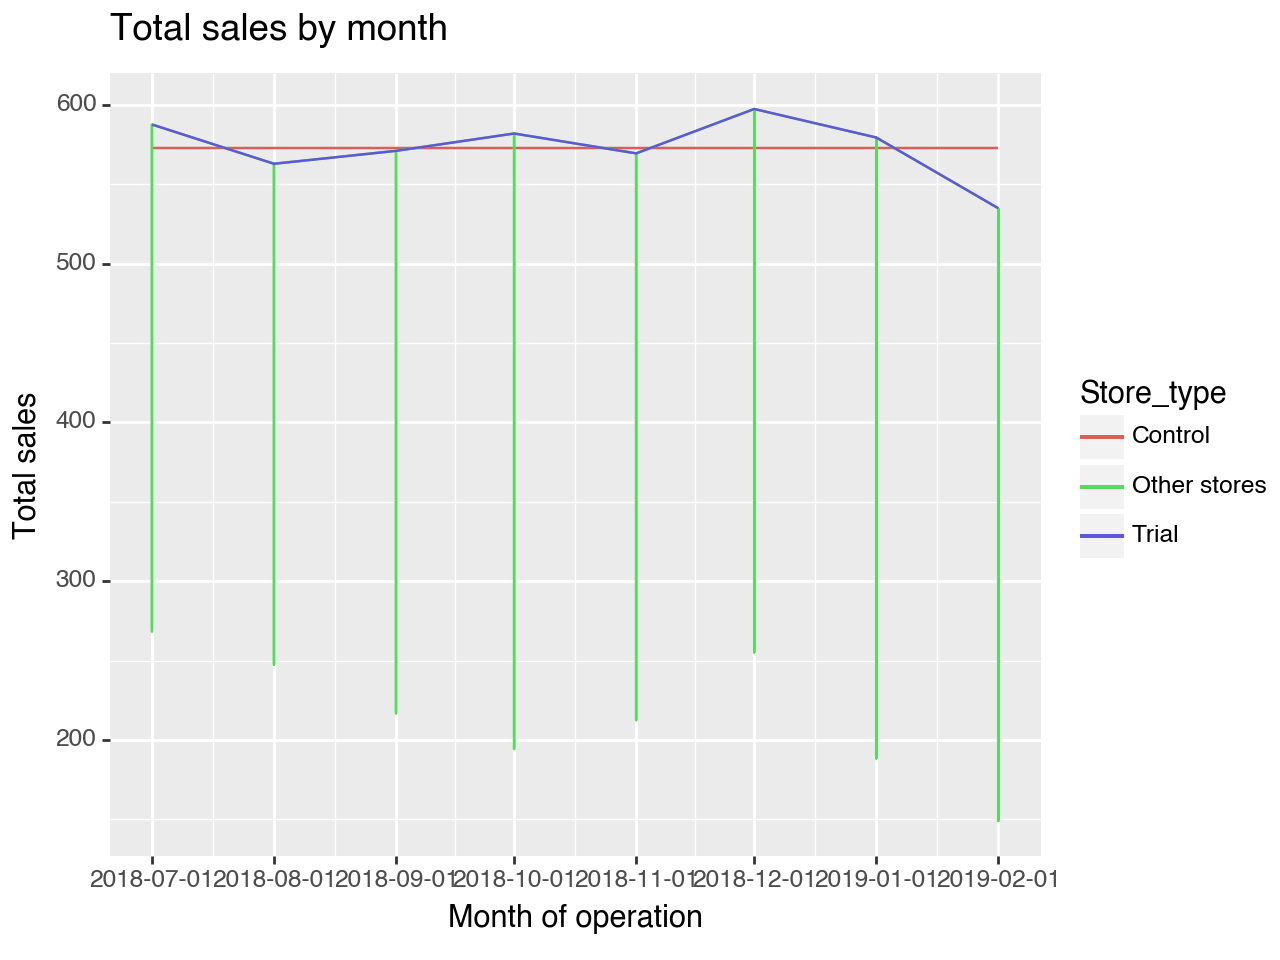

In [126]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_line, labs

# Assuming 'measure_over_time_sales', 'trial_store', and 'control_store' are your DataFrames
measure_over_time_sales = measure_over_time.copy()

# Add 'Store_type' column
measure_over_time_sales['Store_type'] = np.where(
    measure_over_time_sales['STORE_NBR'] == trial_store, 'Trial',
    np.where(measure_over_time_sales['STORE_NBR'] == control_store, 'Control', 'Other stores')
)

# Calculate mean total sales for the control store
measure_over_time_sales.loc[
    measure_over_time_sales['STORE_NBR'] == control_store, 'totSales'
] = measure_over_time_sales.loc[
    measure_over_time_sales['STORE_NBR'] == control_store, 'totSales'
].mean()

# Convert YEARMONTH to TransactionMonth
measure_over_time_sales['TransactionMonth'] = pd.to_datetime(measure_over_time_sales['YEARMONTH'], format='%Y%m')
measure_over_time_sales['MonthAbbrev'] = measure_over_time_sales['TransactionMonth'].dt.strftime('%b')


# Filter data for months before March 2019
past_sales = measure_over_time_sales[measure_over_time_sales['YEARMONTH'] < 201903]

# Create ggplot
plot = (
    ggplot(past_sales, aes(x='TransactionMonth', y='totSales', color='Store_type')) +
    geom_line() +
    labs(x='Month of operation', y='Total sales', title='Total sales by month')
)

# Display the plot
print(plot)


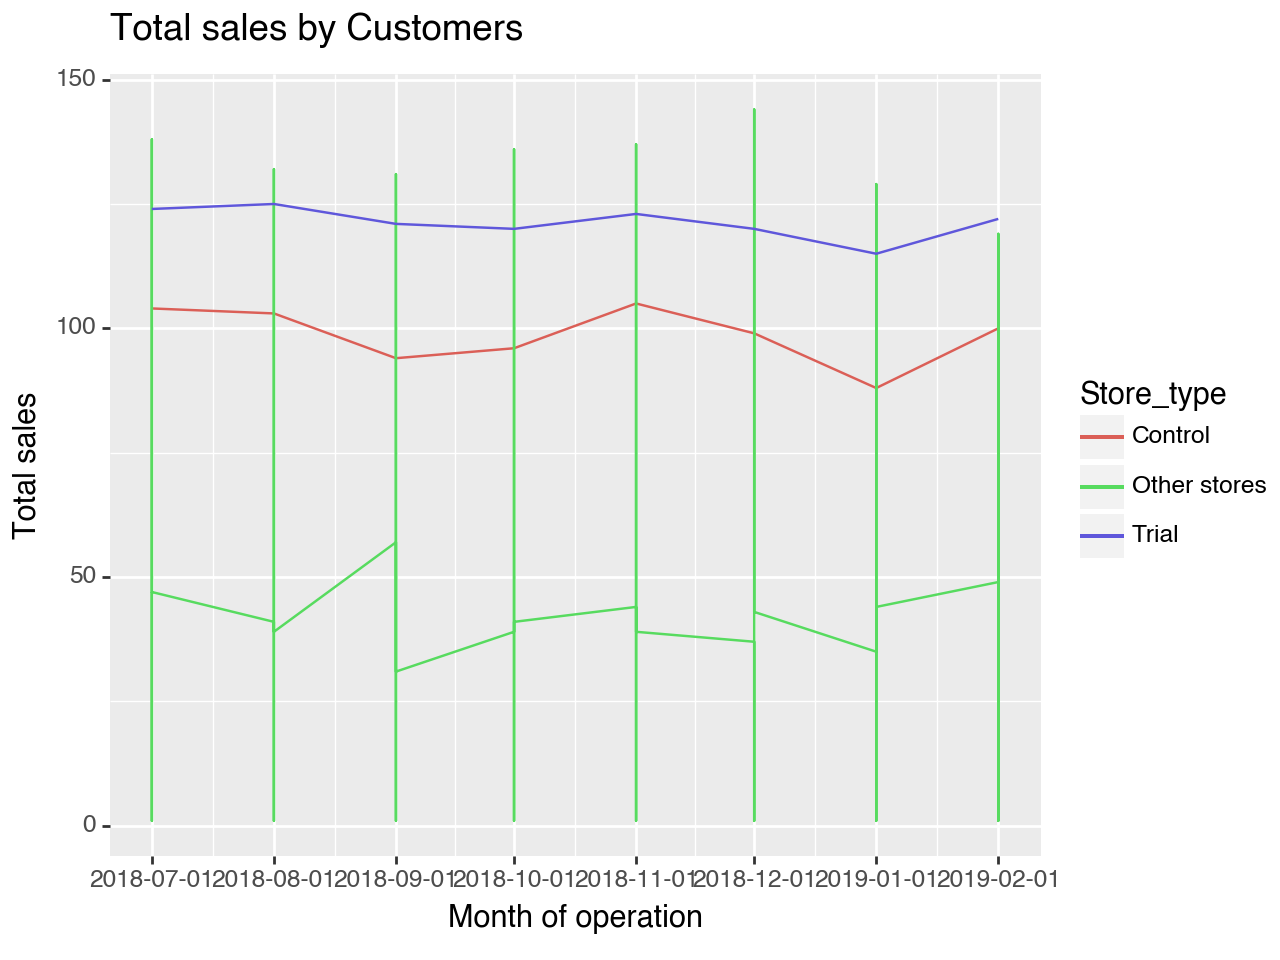

In [127]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_line, labs

# Assuming 'measure_over_time_sales', 'trial_store', and 'control_store' are your DataFrames
measure_over_time_sales = measure_over_time.copy()

# Add 'Store_type' column
measure_over_time_sales['Store_type'] = np.where(
    measure_over_time_sales['STORE_NBR'] == trial_store, 'Trial',
    np.where(measure_over_time_sales['STORE_NBR'] == control_store, 'Control', 'Other stores')
)

# Calculate mean total sales for the control store
measure_over_time_sales.loc[
    measure_over_time_sales['STORE_NBR'] == control_store, 'totSales'
] = measure_over_time_sales.loc[
    measure_over_time_sales['STORE_NBR'] == control_store, 'totSales'
].mean()

# Convert YEARMONTH to TransactionMonth
measure_over_time_sales['TransactionMonth'] = pd.to_datetime(measure_over_time_sales['YEARMONTH'], format='%Y%m')
measure_over_time_sales['MonthAbbrev'] = measure_over_time_sales['TransactionMonth'].dt.strftime('%b')


# Filter data for months before March 2019
past_sales = measure_over_time_sales[measure_over_time_sales['YEARMONTH'] < 201903]

# Create ggplot
plot = (
    ggplot(past_sales, aes(x='TransactionMonth', y='nCustomers', color='Store_type')) +
    geom_line() +
    labs(x='Month of operation', y='Total sales', title='Total sales by Customers')
)

# Display the plot
print(plot)


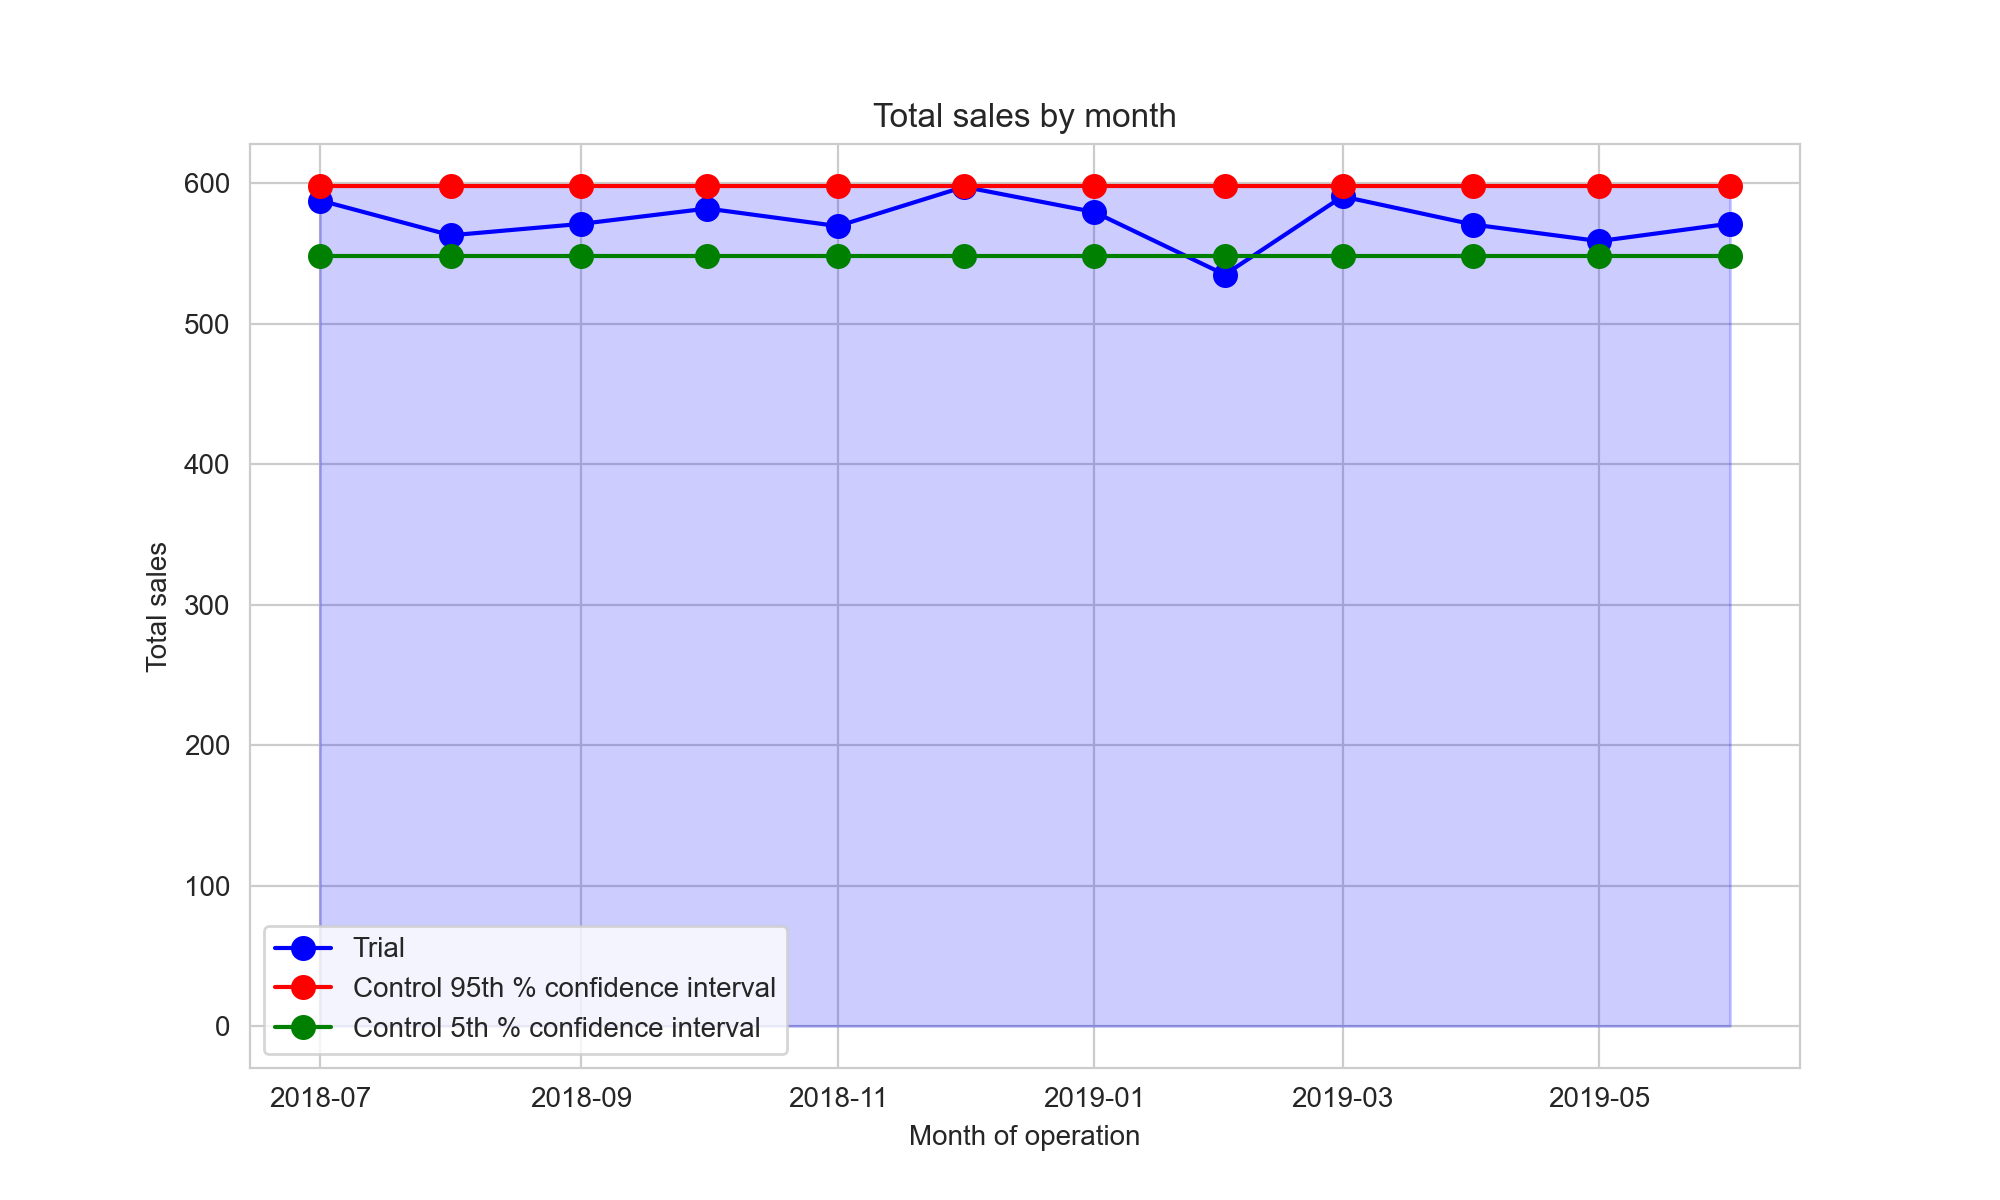

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the equivalent of trialAssessment DataFrame
# Replace this with your actual DataFrame

# Convert 'TransactionMonth' to datetime if it's not already
trialAssessment['TransactionMonth'] = pd.to_datetime(trialAssessment['TransactionMonth'])

# Plotting
plt.figure(figsize=(10, 6))

# Plot Trial
plt.plot(trialAssessment[trialAssessment['Store_type'] == 'Trial']['TransactionMonth'],
         trialAssessment[trialAssessment['Store_type'] == 'Trial']['totSales'],
         marker='o', linestyle='-', markersize=8, color='blue', label='Trial')

# Shade area between 95th % confidence interval and Trial
plt.fill_between(trialAssessment['TransactionMonth'],
                 trialAssessment['totSales'],
                 where=(trialAssessment['Store_type'] == 'Control 95th % confidence interval'),
                 color='blue', alpha=0.2)

# Plot Control 95th % confidence interval
plt.plot(trialAssessment[trialAssessment['Store_type'] == 'Control 95th % confidence interval']['TransactionMonth'],
         trialAssessment[trialAssessment['Store_type'] == 'Control 95th % confidence interval']['totSales'],
         marker='o', linestyle='-', markersize=8, color='red', label='Control 95th % confidence interval')

# Plot Control 5th % confidence interval
plt.plot(trialAssessment[trialAssessment['Store_type'] == 'Control 5th % confidence interval']['TransactionMonth'],
         trialAssessment[trialAssessment['Store_type'] == 'Control 5th % confidence interval']['totSales'],
         marker='o', linestyle='-', markersize=8, color='green', label='Control 5th % confidence interval')

plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Total sales by month")
plt.legend()
plt.show()


The results show that the trial in store 88 is significantly different to its control store in the trial period as the trial store performance lies outside of the 5% to 95% confidence interval of the control store in two of the three trial months. Let’s have a look at assessing this for number of customers as well.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the equivalent of measureOverTimeCusts DataFrame
# Replace this with your actual DataFrame

# Apply the scaling factor
measureOverTimeCusts = measure_over_time.copy()

measureOverTimeCusts['controlCustomers'] = np.where(measureOverTimeCusts['STORE_NBR'] == control_store,
                                                    measureOverTimeCusts['nCustomers'] * scalingFactorForControlCust, 0)

measureOverTimeCusts['Store_type'] = np.where(measureOverTimeCusts['STORE_NBR'] == trial_store, 'Trial',
                                               np.where(measureOverTimeCusts['STORE_NBR'] == control_store, 'Control', 'Other stores'))

# Calculate the absolute percentage difference
percentageDiff = pd.merge(measureOverTimeCusts[['YEARMONTH', 'controlCustomers']],
                          measureOverTimeCusts[measureOverTimeCusts['STORE_NBR'] == trial_store][['nCustomers', 'YEARMONTH']],
                          on='YEARMONTH')

percentageDiff['percentageDiff'] = abs(percentageDiff['controlCustomers'] - percentageDiff['nCustomers']) / percentageDiff['controlCustomers']

# Calculate standard deviation based on scaled percentage difference
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff'].std()
degreesOfFreedom = 7

# Trial and control store number of customers
pastCustomers = measureOverTimeCusts.groupby(['YEARMONTH', 'Store_type']).agg(nCusts=('nCustomers', 'mean')).reset_index()

# Control store 95th percentile
pastCustomers_Controls95 = pastCustomers[pastCustomers['Store_type'] == 'Control'].copy()
pastCustomers_Controls95['nCusts'] = pastCustomers_Controls95['nCusts'] * (1 + stdDev * 2)
pastCustomers_Controls95['Store_type'] = 'Control 95th % confidence interval'

# Control store 5th percentile
pastCustomers_Controls5 = pastCustomers[pastCustomers['Store_type'] == 'Control'].copy()
pastCustomers_Controls5['nCusts'] = pastCustomers_Controls5['nCusts'] * (1 - stdDev * 2)
pastCustomers_Controls5['Store_type'] = 'Control 5th % confidence interval'

# Combine pastCustomers, pastCustomers_Controls95, and pastCustomers_Controls5
trialAssessment = pd.concat([pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(trialAssessment[(trialAssessment['YEARMONTH'] < 201905) & (trialAssessment['YEARMONTH'] > 201901)]['TransactionMonth'],
         trialAssessment[(trialAssessment['YEARMONTH'] < 201905) & (trialAssessment['YEARMONTH'] > 201901)]['nCusts'],
         marker='o', linestyle='-', markersize=8, color='blue', label='Trial')
plt.fill_between(trialAssessment[(trialAssessment['YEARMONTH'] < 201905) & (trialAssessment['YEARMONTH'] > 201901)]['TransactionMonth'],
                 0, trialAssessment[(trialAssessment['YEARMONTH'] < 201905) & (trialAssessment['YEARMONTH'] > 201901)]['nCusts'],
                 color='blue', alpha=0.2)
plt.plot(trialAssessment[trialAssessment['Store_type'] == 'Control 95th % confidence interval']['TransactionMonth'],
         trialAssessment[trialAssessment['Store_type'] == 'Control 95th % confidence interval']['nCusts'],
         marker='o', linestyle='-', markersize=8, color='red', label='Control 95th % confidence interval')
plt.plot(trialAssessment[trialAssessment['Store_type'] == 'Control 5th % confidence interval']['TransactionMonth'],
         trialAssessment[trialAssessment['Store_type'] == 'Control 5th % confidence interval']['nCusts'],
         marker='o', linestyle='-', markersize=8, color='green', label='Control 5th % confidence interval')
plt.xlabel("Month of operation")
plt.ylabel("Total number of customers")
plt.title("Total number of customers by month")
plt.legend()
plt.show()


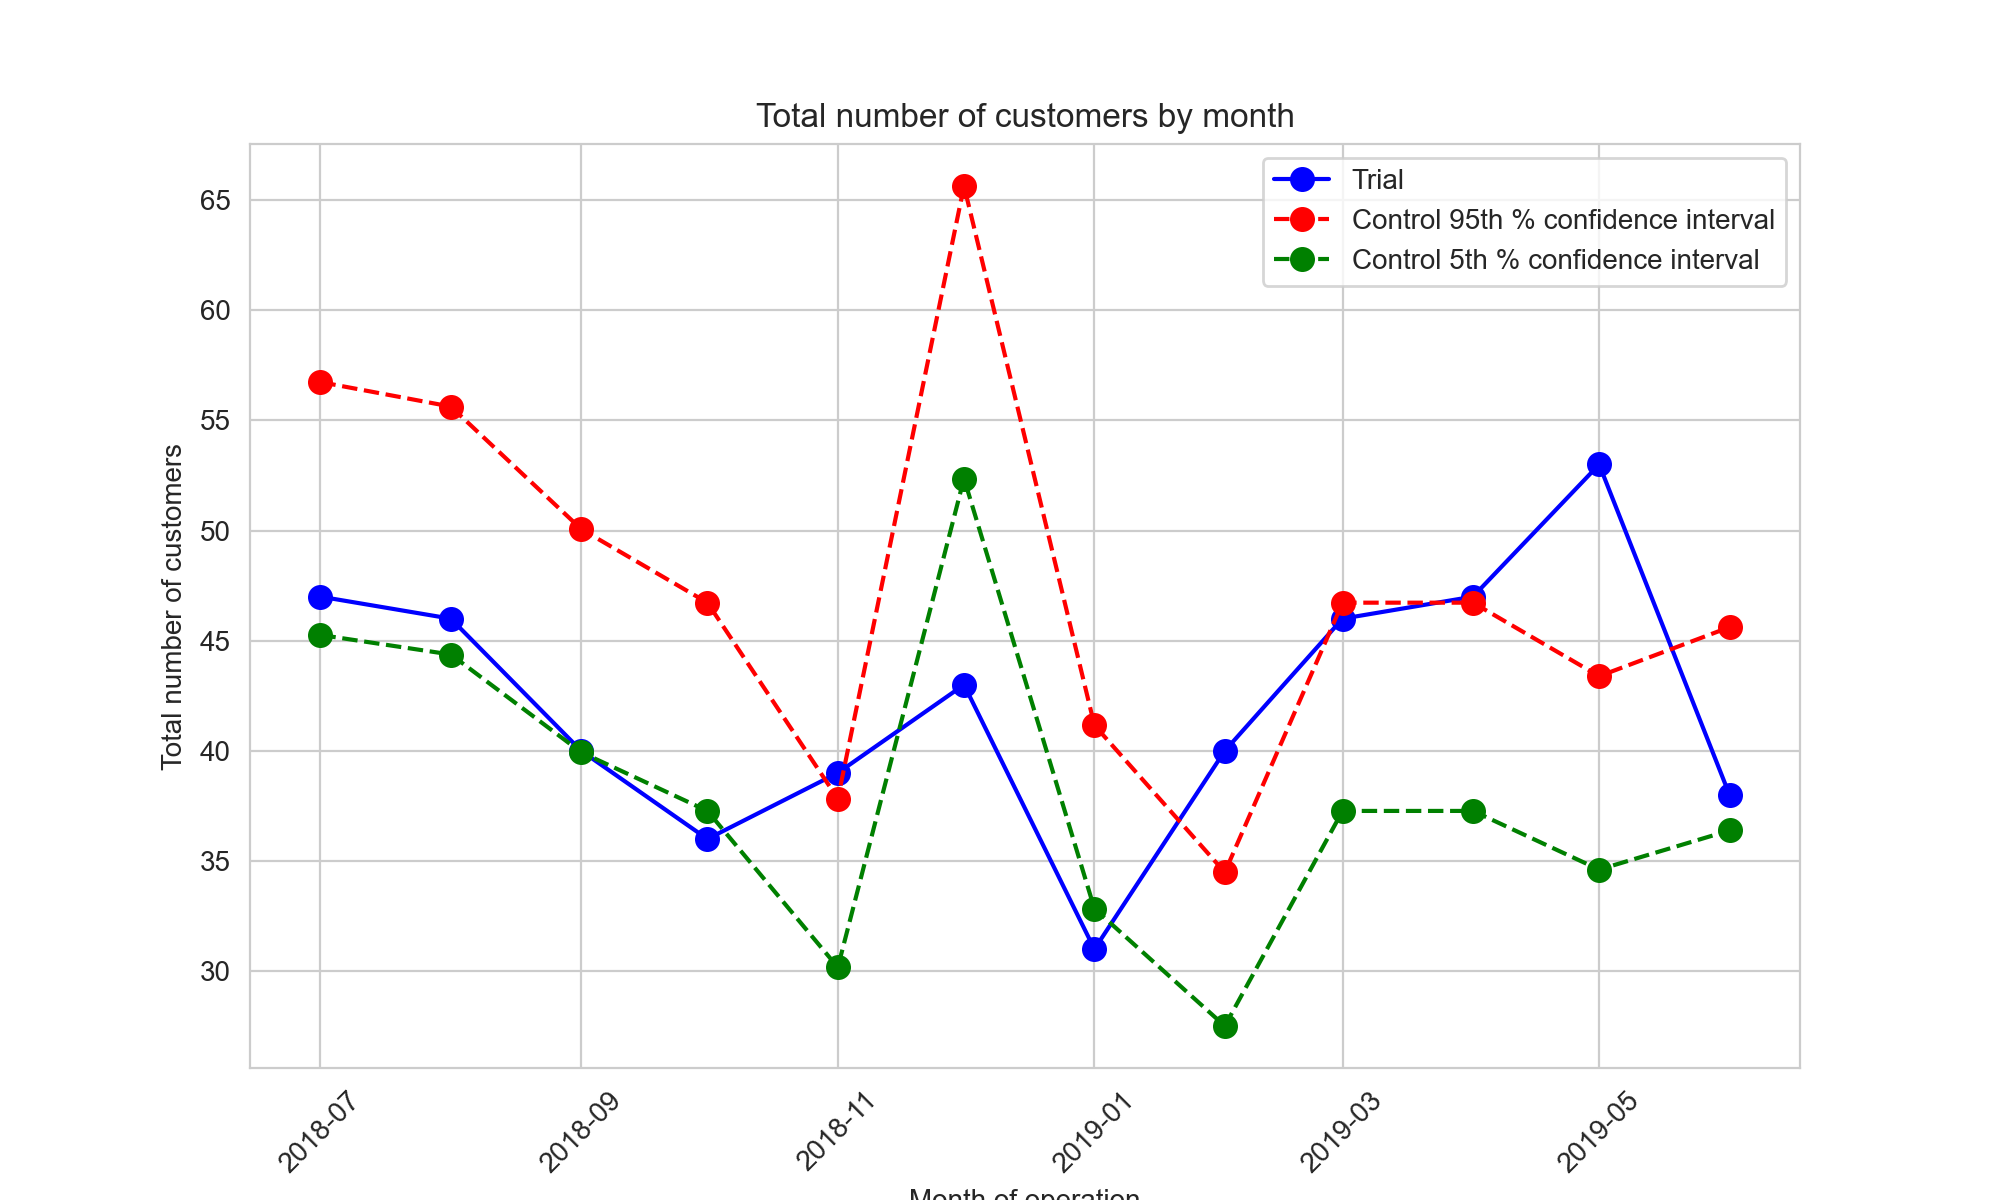

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the equivalent of measureOverTimeSales DataFrame
# Replace this with your actual DataFrame

# Apply the scaling factor to control store customers
scaledControlCustomers = measure_over_time[measure_over_time['STORE_NBR'] == control_store].copy()
scaledControlCustomers['controlCustomers'] = scaledControlCustomers['nCustomers'] * scalingFactorForControlCust
scaledControlCustomers['Store_type'] = np.where(scaledControlCustomers['STORE_NBR'] == trial_store, 'Trial',
                                                np.where(scaledControlCustomers['STORE_NBR'] == control_store, 'Control', 'Other stores'))

# Calculate the absolute percentage difference
percentageDiff = pd.merge(scaledControlCustomers[['YEARMONTH', 'controlCustomers']],
                         measure_over_time[measure_over_time['STORE_NBR'] == trial_store][['YEARMONTH', 'nCustomers']],
                         on='YEARMONTH')
percentageDiff['percentageDiff'] = abs(percentageDiff['controlCustomers'] - percentageDiff['nCustomers']) / percentageDiff['controlCustomers']

# Calculate standard deviation
stdDev = percentageDiff[percentageDiff['YEARMONTH'] < 201902]['percentageDiff'].std()

# Trial and control store number of customers
pastCustomers = measure_over_time.copy()
pastCustomers['nCusts'] = pastCustomers.groupby(['YEARMONTH', 'Store_type'])['nCustomers'].transform('mean')
pastCustomers = pastCustomers[pastCustomers['Store_type'].isin(['Trial', 'Control'])]

# Control store 95th percentile
pastCustomers_Controls95 = pastCustomers[pastCustomers['Store_type'] == 'Control'].copy()
pastCustomers_Controls95['nCusts'] = pastCustomers_Controls95['nCusts'] * (1 + stdDev * 2)
pastCustomers_Controls95['Store_type'] = 'Control 95th % confidence interval'

# Control store 5th percentile
pastCustomers_Controls5 = pastCustomers[pastCustomers['Store_type'] == 'Control'].copy()
pastCustomers_Controls5['nCusts'] = pastCustomers_Controls5['nCusts'] * (1 - stdDev * 2)
pastCustomers_Controls5['Store_type'] = 'Control 5th % confidence interval'

# Combine pastCustomers, pastCustomers_Controls95, and pastCustomers_Controls5
trialAssessment = pd.concat([pastCustomers, pastCustomers_Controls95, pastCustomers_Controls5])

# Plotting
plt.figure(figsize=(10, 6))

# Plot Trial
plt.plot(trialAssessment[trialAssessment['Store_type'] == 'Trial']['TransactionMonth'],
         trialAssessment[trialAssessment['Store_type'] == 'Trial']['nCusts'],
         marker='o', linestyle='-', markersize=8, color='blue', label='Trial')

# Create separate DataFrames for 95th and 5th percentiles
control_95th = trialAssessment[trialAssessment['Store_type'] == 'Control 95th % confidence interval']
control_5th = trialAssessment[trialAssessment['Store_type'] == 'Control 5th % confidence interval']

# Plot Control 95th % confidence interval
plt.plot(control_95th['TransactionMonth'], control_95th['nCusts'],
         marker='o', linestyle='dashed', markersize=8, color='red', label='Control 95th % confidence interval')

# Plot Control 5th % confidence interval
plt.plot(control_5th['TransactionMonth'], control_5th['nCusts'],
         marker='o', linestyle='dashed', markersize=8, color='green', label='Control 5th % confidence interval')

# Add this line to show all plotted lines
plt.legend()

plt.xlabel("Month of operation")
plt.ylabel("Total number of customers")
plt.title("Total number of customers by month")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()


The total number of customers during the test period for the pilot store is significantly higher than the control store for two out of three months, indicating a positive effect of the test period.  We found control stores of 233, 155 and 237 for test stores 77, 86 and 88 respectively. The results for control stores 77 and 88 during the test period show a significant difference for at least two of the three test months, but this is not the case for control store 86. We can check with the customer whether the implementation of the test was different in pilot store 86, but overall, the test shows a significant increase in sales. Now that we've completed our analysis, we can prepare our presentation to the category manager.